In [1]:
import numpy as np
import pandas as pd

# from atomic_forces.average_atom.python.average_atom import NeutralPseudoAtom as NPA
from atomic_forces.average_atom.python.average_atom_geometric import NeutralPseudoAtom as NPA
from atomic_forces.average_atom.python.average_atom_geometric import load_NPA
from atomic_forces.average_atom.python.misc import jacobi_relaxation, sor
from atomic_forces.average_atom.python.grids import NonUniformGrid
# from atomic_forces.average_atom.python.average_atom import load_NPA
from atomic_forces.atomOFDFT.python.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from atomic_forces.atomOFDFT.python import physics as physics
    from atomic_forces.average_atom.python import average_atom_geometric as average_atom_geometric
#     from atomic_forces.average_atom.python import average_atom as average_atom
    from atomic_forces.average_atom.python import misc as misc
    from atomic_forces.average_atom.python import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)


import matplotlib.pyplot as plt

from hnc.hnc.constants import *

import cProfile



ModuleNotFoundError: No module named 'mendeleev'
Error:  name 'physics' is not defined


In [2]:
# Aluminum 
name='Al'
Z, A = 13, 27 
T_eV = 1 
T_AU = T_eV*eV_to_AU
rs = 2.985767276908717


# # Carbon
# name='C'
# Z, A = 6,12 
# T_eV = 2 
# T_AU = T_eV*eV_to_AU
# rs = 1.4758761033327266


# # Hydrogen
# name='H'
# Z, A = 1,1 
# T_eV = 2 
# T_AU = T_eV*eV_to_AU
# rs = 1.390838427724567

# from hnc.hnc.misc import rs_from_n
# # Xenon
# name='Xe'
# Z, A = 54, 131.293 
# T_eV = 10e3*K_to_eV 
# T_AU = T_eV*eV_to_AU
# rs = rs_from_n(2e20*invcc_to_AU)

# # Vanadium
# name='V'
# Z, A = 23, 50.9415
# T_eV = 0.5 
# T_AU = T_eV*eV_to_AU
# rs = rs_from_n(6.11/(A*amu_to_AU*AU_to_g)*invcc_to_AU)



####
R = rs

aa_tfd = NPA(Z, A, T_AU, rs, R, initialize=True, gradient_correction=None, μ_init = None, Zstar_init = 3, rmin=5e-4 ,Npoints=200, name=name,ignore_vxc=False)
aa_tfdw_λ1 = NPA(Z, A, T_AU, rs, R, initialize=True, gradient_correction='W', Weizsacker_λ=1, μ_init = None, Zstar_init = 3, rmin=5e-4 ,Npoints=200, name=name,ignore_vxc=False)
aa_tfdw_λover9 = NPA(Z, A, T_AU, rs, R, initialize=True, gradient_correction='W', Weizsacker_λ=1/9, μ_init = None, Zstar_init = 3, rmin=5e-4 ,Npoints=200, name=name,ignore_vxc=False)


Intializing grid
Loading Data for Comparison (from George Petrov)
Z err: 0.004210521971535206
Intialized Potentials and Densities
Intializing grid


/home/zach/plasma/atomic_forces/GordonKim/python/atoms.py:75: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Z_unnorm, err = quad(rho_integrand, 0, self.rs, limit=500, epsabs=1e-5, epsrel=1e-5)


Loading Data for Comparison (from George Petrov)
Z err: 0.004210521971535206
Intialized Potentials and Densities
Intializing grid


/home/zach/plasma/atomic_forces/GordonKim/python/atoms.py:75: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Z_unnorm, err = quad(rho_integrand, 0, self.rs, limit=500, epsabs=1e-5, epsrel=1e-5)


Loading Data for Comparison (from George Petrov)
Z err: 0.004210521971535206
Intialized Potentials and Densities


/home/zach/plasma/atomic_forces/GordonKim/python/atoms.py:75: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Z_unnorm, err = quad(rho_integrand, 0, self.rs, limit=500, epsabs=1e-5, epsrel=1e-5)


### Thomas Fermi (TF)

In [3]:
from hnc.hnc.misc import ThomasFermiZbar as MoreZbar

MoreZbar(Z, 2e20, 1e4*K_to_eV)

0.6861374664783618

In [7]:
aa_tfd.solve_TF(verbose=True, picard_alpha=0.5)
# aa_tfd.update_bound_free()

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =     0.0741, change: 4.9663e-04
	Poisson Err = -6.035e-13, rho Err =  3.346e-06
	Q =  0.000e+00 -> -7.995e-04, 
	Zstar guess =  3.097e+00. Current Zstar:  2.754e+00
	Change =  3.513e-04
__________________________________________
TF Iteration 1
	mu =     0.0741, change: 0.0000e+00
	Poisson Err = -5.586e-13, rho Err =  2.770e-06
	Q = -7.995e-04 -> -5.867e-04, 
	Zstar guess =  3.097e+00. Current Zstar:  2.823e+00
	Change =  2.028e-08


True

In [39]:
def fix_bound_free(aa):
    φ_shift =  aa.φe[aa.rws_index]+ aa.φion[aa.rws_index] -aa.vxc_f(aa.ne)[aa.rws_index] # Can escape rs
    
    if aa.gradient_correction is not None:
        φ_shift +=  - aa.get_gradient_energy(aa.ne)  # Can escape rs
        
    aa.Zstar = aa.update_bound_free(φ_shift)
    
fix_bound_free(aa_tfd)
aa_tfd.Zstar

/home/zach/plasma/atomic_forces/atomOFDFT/python/physics.py:93: RuntimeWarning: overflow encountered in exp
  integrand = lambda x:  (x**0.5/(np.exp(x-eta) + 1)).real
/home/zach/plasma/atomic_forces/atomOFDFT/python/physics.py:95: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  integral, info = quad(integrand, xmid, x_infinite, limit=50, epsabs=1e-15, epsrel=1e-5) # x0 to infinity


3.3001302804767327

In [40]:
# Zstar_list = []
# aa_tfd_list = []
# for T_AU in np.geomspace(3e3,5e4, num=30)*K_to_AU:
#     aa_tfd = NPA(Z, A, T_AU, rs, R, initialize=True, gradient_correction=None, μ_init = None, Zstar_init = 3, rmin=5e-4 ,Npoints=200, name=name,ignore_vxc=False)
#     aa_tfd.solve_TF(verbose=True, picard_alpha=1e-2)
#     aa_tfd.update_bound_free()
#     fix_bound_free(aa_tfd)
#     aa_tfd.ne = aa_tfd.ne + 1e-1
#     Zstar_list.append(aa_tfd.Zstar)
#     aa_tfd_list.append(aa_tfd)
    

### Thomas Fermi Weizsacker (λ=1)

In [8]:
cutoff_point = 0.02
cutoff_index = np.argmin(np.abs(  cutoff_point - np.array([aa_tfd.grid.integrate_f(aa_tfd.ne, end_index = i) for i in range(len(aa_tfd.ne))])))
guess_tfdw_ne = 1/(  1/aa_tfd.ne + 1/aa_tfd.ne[cutoff_index])

aa_tfdw_λ1.ne = guess_tfdw_ne.copy()
aa_tfdw_λ1.μ  = aa_tfd.μ

In [9]:
%%time
aa_tfdw_λ1.solve_TF(verbose=True, picard_alpha = 1e-2)

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =    -0.1891, change: 3.5542e+00
	Poisson Err = -1.184e-12, rho Err =  1.641e-02
	Q =  0.000e+00 ->  1.043e-01, 
	Zstar guess =  3.229e+00. Current Zstar:  3.046e+00
	Change =  1.899e+00
__________________________________________
TF Iteration 1
	mu =    -0.2027, change: 7.1772e-02
	Poisson Err = -1.894e-12, rho Err =  1.591e-02
	Q =  1.043e-01 ->  1.212e-01, 
	Zstar guess =  8.053e-01. Current Zstar:  2.598e+00
	Change =  5.949e-02
__________________________________________
TF Iteration 2
	mu =    -0.2118, change: 4.4887e-02
	Poisson Err = -7.569e-13, rho Err =  1.554e-02
	Q =  1.212e-01 ->  1.351e-01, 
	Zstar guess =  7.086e-01. Current Zstar:  2.220e+00
	Change =  4.014e-02
__________________________________________
TF Iteration 3
	mu =    -0.2196, change: 3.6588e-02
	Poisson Err = -2.282e-12, rho Err =  1.521e-02
	Q =  1.351e-01 ->  1.469e-01, 
	


KeyboardInterrupt



In [10]:
fix_bound_free(aa_tfdw_λ1)
aa_tfdw_λ1.Zstar


NameError: name 'fix_bound_free' is not defined

### Thomas Fermi Weizsacker λ=1/9

In [11]:
%%time

aa_tfdw_λover9.ne = guess_tfdw_ne.copy()
aa_tfdw_λover9.μ  = aa_tfd.μ

aa_tfdw_λover9.solve_TF(verbose=True, picard_alpha = 1e-3, tol=1e-6)

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =     0.0250, change: 6.6208e-01
	Poisson Err = -1.184e-12, rho Err =  1.366e-03
	Q =  0.000e+00 ->  8.127e-02, 
	Zstar guess =  3.180e+00. Current Zstar:  3.036e+00
	Change =  1.224e+00
__________________________________________
TF Iteration 1
	mu =     0.0238, change: 4.7155e-02
	Poisson Err = -2.533e-12, rho Err =  1.400e-03
	Q =  8.127e-02 ->  8.139e-02, 
	Zstar guess =  2.807e+00. Current Zstar:  2.990e+00
	Change =  3.490e-02
__________________________________________
TF Iteration 2
	mu =     0.0237, change: 4.6475e-03
	Poisson Err = -1.922e-12, rho Err =  1.407e-03
	Q =  8.139e-02 ->  8.148e-02, 
	Zstar guess =  2.797e+00. Current Zstar:  2.952e+00
	Change =  3.716e-03
__________________________________________
TF Iteration 3
	mu =     0.0237, change: 0.0000e+00
	Poisson Err = -1.550e-12, rho Err =  1.414e-03
	Q =  8.148e-02 ->  8.156e-02, 
	


KeyboardInterrupt



In [46]:
# fix free and bound cutoff
fix_bound_free(aa_tfdw_λover9)
aa_tfdw_λover9.Zstar

3.273207337958965

## Comparison

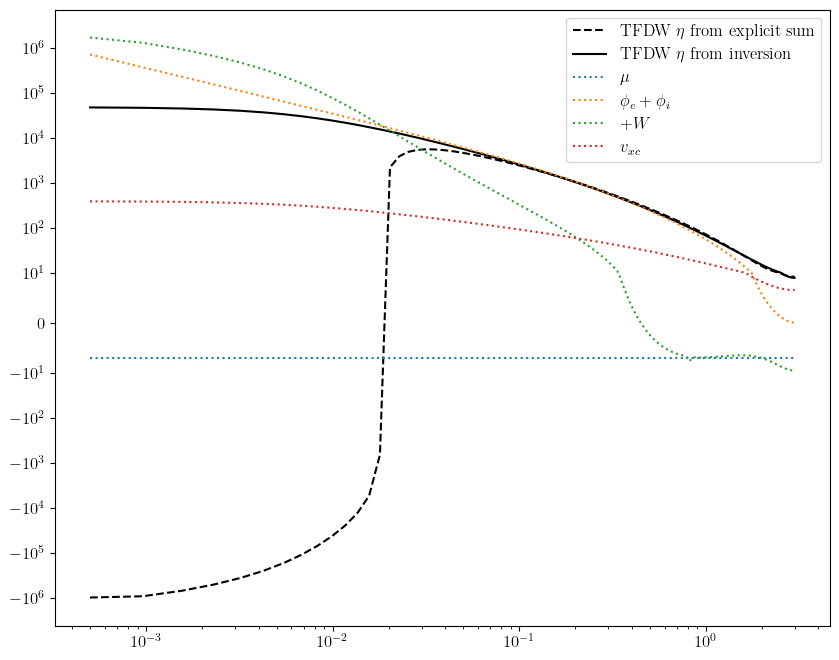

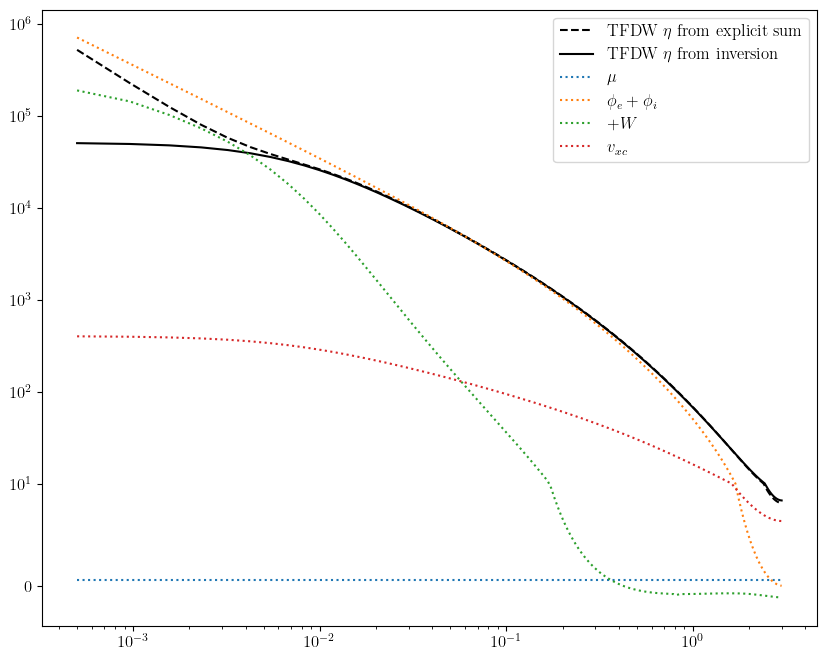

In [12]:
def compare_η(aa):
    fig, ax = plt.subplots(figsize=(10,8))

    # ax.plot(aa_tfd.grid.xs, aa_tfd.get_eta_from_sum(aa_tfd.ne, aa_tfd.μ) -aa_tfd.μ/aa_tfd.T,'k--', label=r'TF $\eta$')
    ax.plot(aa.grid.xs, aa.get_eta_from_sum(aa.ne, aa.μ),'k--', label=r'TFDW $\eta$ from explicit sum') 
    ax.plot(aa.grid.xs, aa.TF.η_interp(aa.ne),'k-', label=r"TFDW $\eta$ from inversion") 

    # pieces
    pieces=[aa.μ*np.ones_like(aa.ne), aa.φe+ aa.φion, + aa.get_gradient_energy(aa.ne), - aa.vxc_f(aa.ne) ]
    labels=[r'$\mu$',r'$\phi_{e}+\phi_{i}$',r'$+W$',r'$v_{xc}$']

    for piece, label in zip(pieces, labels): 
        ax.plot(aa.grid.xs, piece/aa.T,':', label=label )


    # plot parameters
    ax.set_yscale('symlog',linthresh=1e1)

    ax.set_xscale('log')
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)
    
compare_η(aa_tfdw_λ1)
compare_η(aa_tfdw_λover9)

0
0
0
0
2
0
2
0
2


(<Figure size 2400x800 with 3 Axes>,
 <Axes: xlabel='$r $ [au]', ylabel='$4 \\pi r^2 n_e $'>)

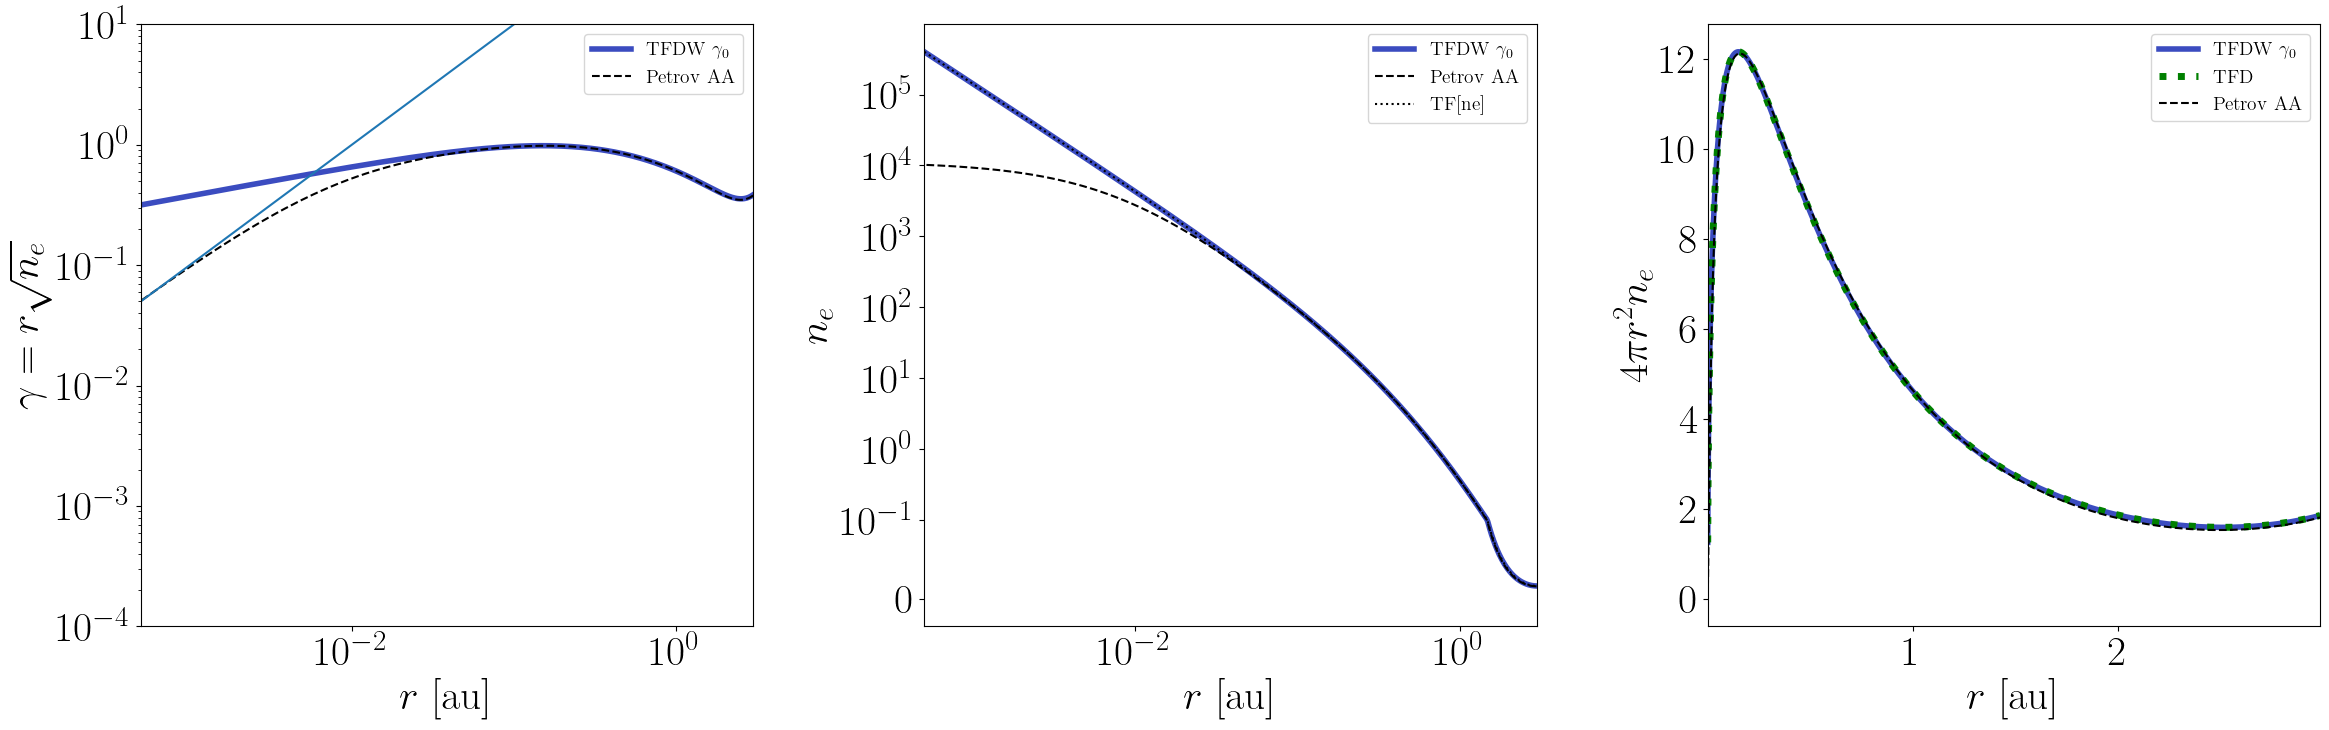

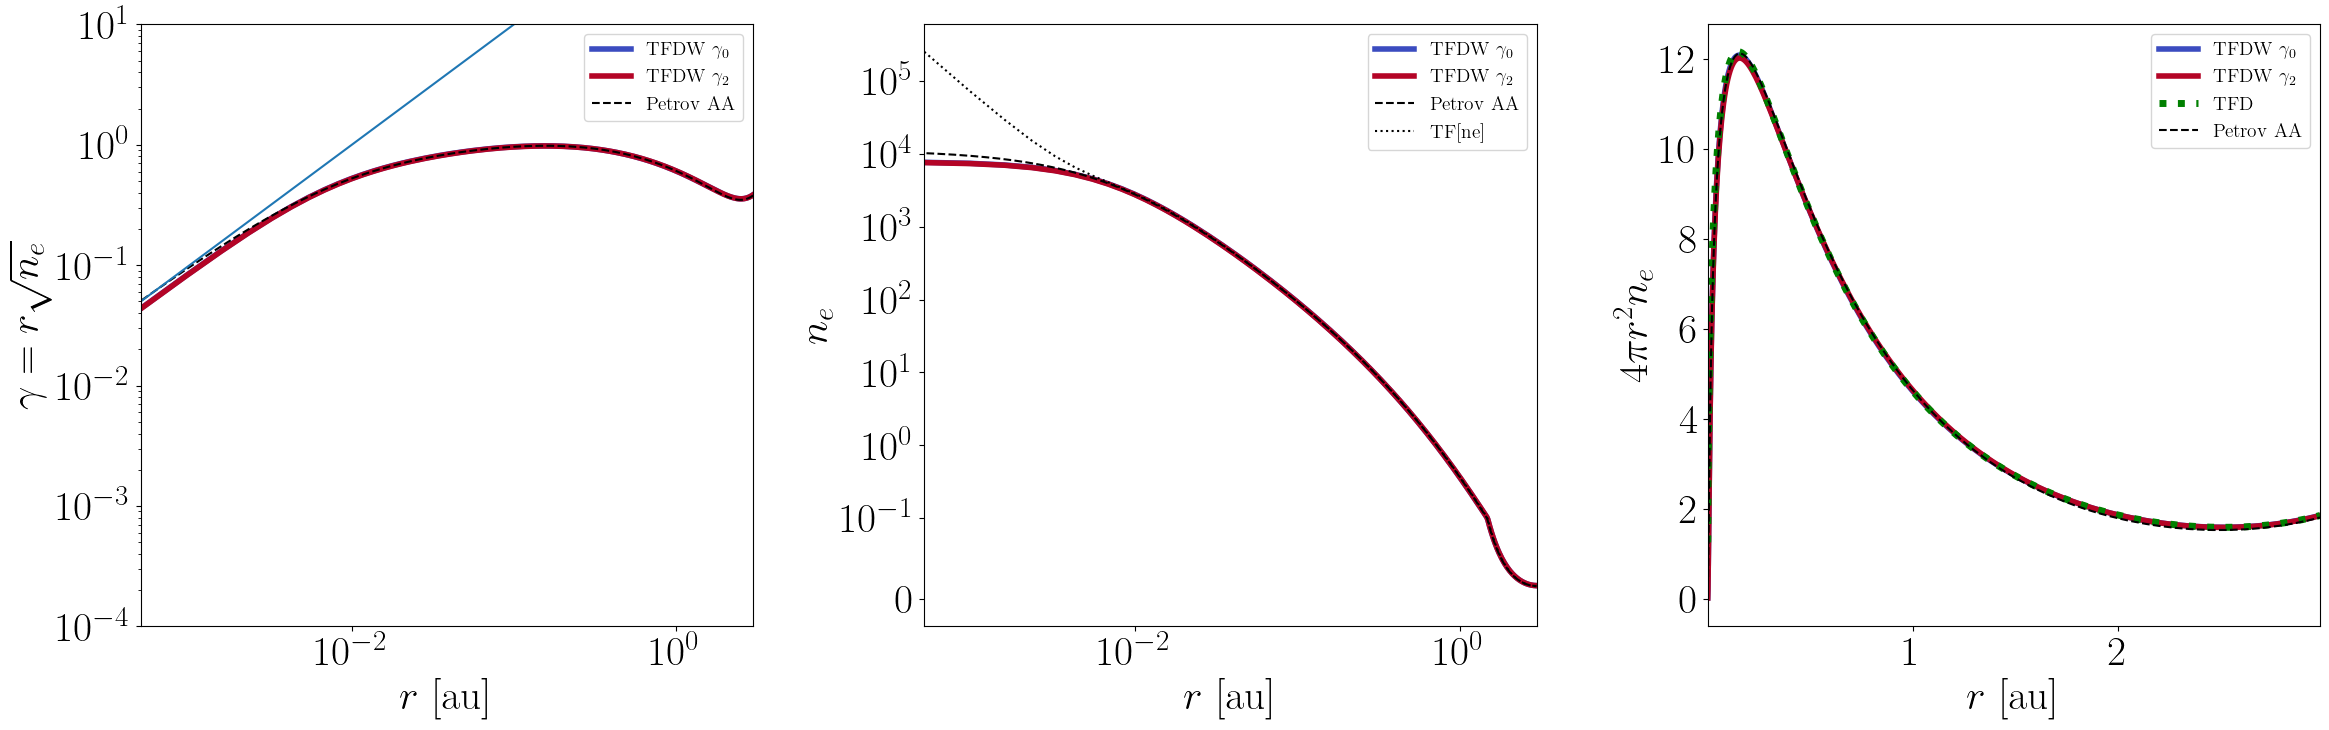

In [13]:
def density_convergence(aa_tfdw):
    fig, axs = plt.subplots(1,3, figsize=(24,8))
    
    ne_list = aa_tfdw.ne_list[::10]
    colors = plt.cm.coolwarm(np.linspace(0, 1,len(ne_list)))

    ax = axs[0]
    for i, ne in enumerate(ne_list):
        if i ==0 or i==len(ne_list)-1:
            print(i)
            ax.plot(aa_tfdw.grid.xs, aa_tfdw.grid.xs*np.sqrt(ne),linewidth=4,color=colors[i],alpha=1, label=r'TFDW $\gamma_{{ {0} }}$'.format(i))
        else:
            ax.plot(aa_tfdw.grid.xs, aa_tfdw.grid.xs*np.sqrt(ne),linewidth=4,color=colors[i],alpha=0.05)
    ax.plot(aa_tfd.petrov.r_data, aa_tfd.petrov.r_data*np.sqrt(aa_tfd.petrov.rho_data + aa_tfd.petrov.rho_0), 'k--', label="Petrov AA")


    ax.plot(aa_tfdw.grid.xs, aa_tfdw.grid.xs*100)
    ax.set_yscale('log')
    ax.set_ylim(1e-4,1e1)
    ax.set_xscale('log')
    ax.set_xlim(np.min(aa_tfdw.grid.xs), rs)

    ax.set_ylabel(r"$\gamma = r \sqrt{n_e}$")
    ax.set_xlabel(r"$r $ [au]")
    ax.legend(fontsize=14)

    ax = axs[1]
    for i, ne in enumerate(ne_list):
        if i ==0 or i==len(ne_list)-1:
            print(i)
            ax.plot(aa_tfdw.grid.xs, ne,linewidth=4,color=colors[i],alpha=1, label=r'TFDW $\gamma_{{ {0} }}$'.format(i))
        else:
            ax.plot(aa_tfdw.grid.xs, ne,linewidth=4,color=colors[i],alpha=0.05)

    ax.plot(aa_tfd.petrov.r_data, aa_tfd.petrov.rho_data + aa_tfd.petrov.rho_0, 'k--', label="Petrov AA")

    ax.plot(aa_tfdw.grid.xs, aa_tfdw.get_ne_TF(aa_tfdw.ne, aa_tfdw.μ),'k:', label='TF[ne]')


    aa_tfd.grid.integrate_f(aa_tfd.ne)


    # ax.plot(aa_tfd.grid.xs, guess_tfd_ne , 'g:',linewidth=5, label="TFD guess")   

    ax.set_yscale('symlog',linthresh=0.1)
    # ax.set_ylim(-1e4,1e5)
    ax.set_xscale('log')

    ax.set_ylabel(r"$n_e $")
    ax.set_xlabel(r"$r $ [au]")
    ax.legend(fontsize=14)
    ax.set_xlim(np.min(aa_tfdw.grid.xs), rs)
    ax = axs[2]
    for i, ne in enumerate(ne_list):
        if i ==0 or i==len(ne_list)-1:
            print(i)
            ax.plot(aa_tfdw.grid.xs, aa_tfdw.grid.xs**2*4*π*ne,linewidth=4,color=colors[i],alpha=1, label=r'TFDW $\gamma_{{ {0} }}$'.format(i))
        else:
            ax.plot(aa_tfdw.grid.xs, aa_tfdw.grid.xs**2*4*π* ne,linewidth=4,color=colors[i],alpha=0.01)        

    ax.plot(aa_tfd.grid.xs, 4*π*aa_tfd.grid.xs**2*aa_tfd.ne, 'g:',linewidth=5, label="TFD")   
    ax.plot(aa_tfd.petrov.r_data, 4*π*aa_tfd.petrov.r_data**2*(aa_tfd.petrov.rho_data + aa_tfd.petrov.rho_0), 'k--', label="Petrov AA")

    # ax.set_yscale('symlog',linthresh=0.1)
    # ax.set_ylim(-1e4,1e5)
    # ax.set_xscale('log')
    ax.set_xlim(np.min(aa_tfdw.grid.xs), rs)
    ax.set_ylabel(r"$4 \pi r^2 n_e $")
    ax.set_xlabel(r"$r $ [au]")
    ax.legend(fontsize=14)
    plt.tight_layout()
    
    return fig, ax


density_convergence(aa_tfd)
# density_convergence(aa_tfdw_λ1)
density_convergence(aa_tfdw_λover9)



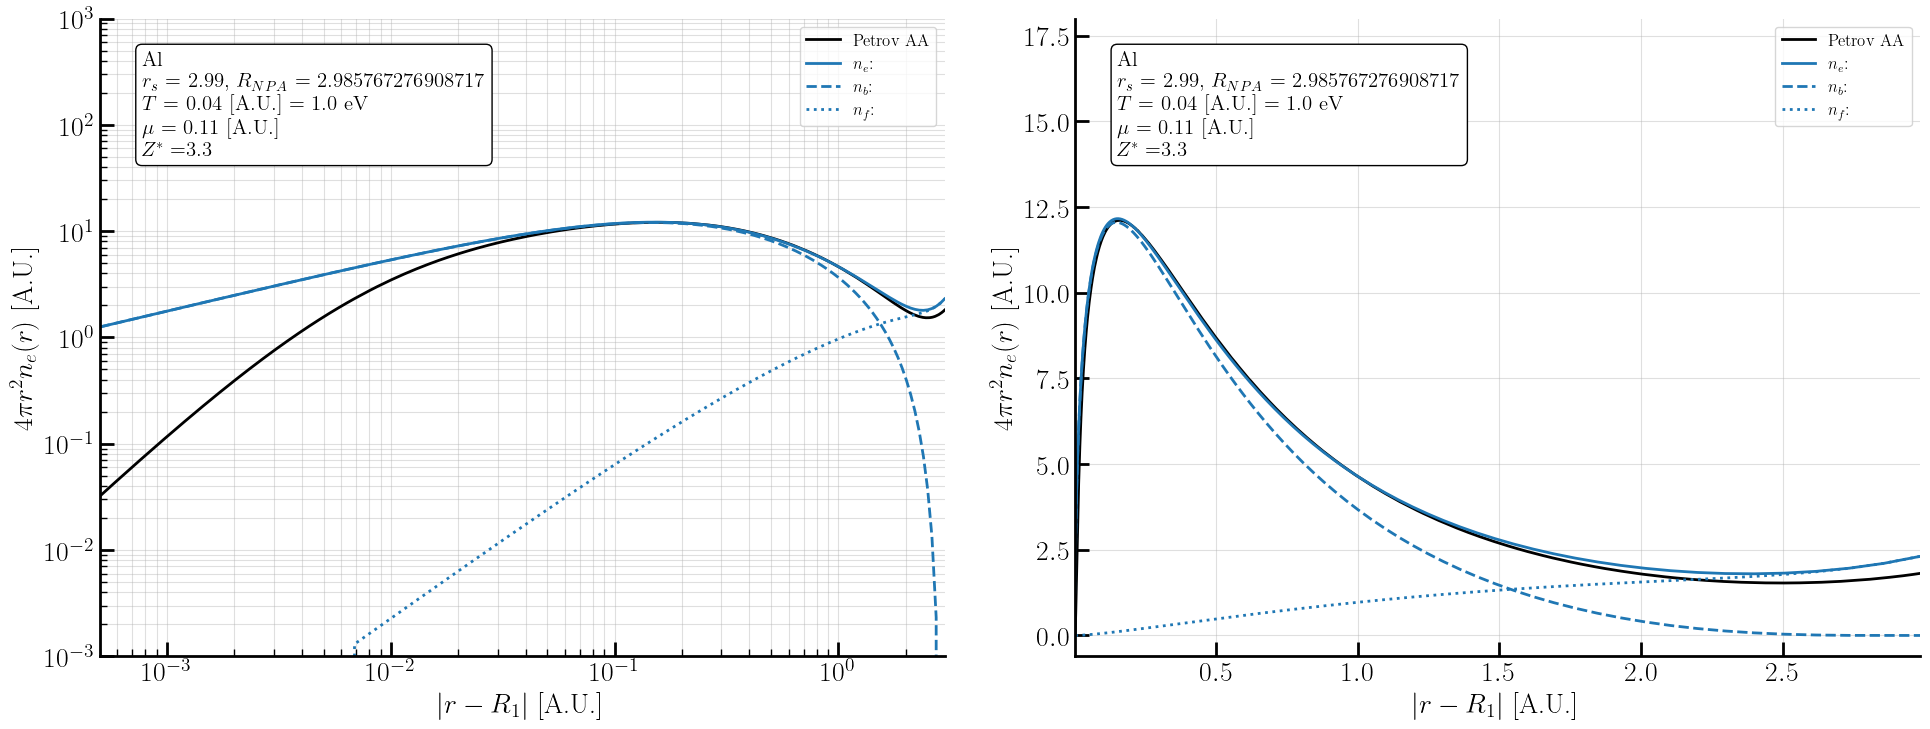

In [50]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def make_plot_bound_free(aa, axs=None, name='', color=colors[0]):
    eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
    if axs is None:
        fig, axs = plt.subplots(ncols=2,figsize=(20,8),facecolor='w')

    # Density * 4pi r^2 plot
    factor = 4*np.pi*aa.grid.xs**2
    axs[0].plot(aa.petrov.r_data, 4*np.pi*aa.petrov.r_data**2*(aa.petrov.rho_data + aa.petrov.rho_0), 'k-', label="Petrov AA")
    axs[0].plot(aa.grid.xs, aa.ne*factor ,'-',color=color, label=r'$n_e$: '+ name)
    axs[0].plot(aa.grid.xs, aa.n_b*factor,'--',color=color,  label=r'$n_b$: ' + name)
    axs[0].plot(aa.grid.xs, aa.n_f*factor,':',color=color,  label=r'$n_f$: ' + name)


    axs[0].set_ylabel(r'$4 \pi r^2 n_e(r) $ [A.U.]',fontsize=20)
    axs[0].set_ylim(1e-3, 1e3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')

    
    # Density * 4pi r^2 plot
    factor = 4*np.pi*aa.grid.xs**2
    axs[1].plot(aa.petrov.r_data, 4*np.pi*aa.petrov.r_data**2*(aa.petrov.rho_data + aa.petrov.rho_0), 'k-', label="Petrov AA")
    axs[1].plot(aa.grid.xs, aa.ne*factor ,'-',color=color, label=r'$n_e$: '+ name)
    axs[1].plot(aa.grid.xs, aa.n_b*factor,'--',color=color,  label=r'$n_b$: ' + name)
    axs[1].plot(aa.grid.xs, aa.n_f*factor,':',color=color,  label=r'$n_f$: ' + name)


    axs[1].set_ylabel(r'$4 \pi r^2 n_e(r) $ [A.U.]',fontsize=20)
    axs[1].set_ylim(None, 18)

        
    for ax in axs:
        ax.set_xlim(aa.grid.xs[0],aa.grid.xs[-1])
        ax.set_xlabel(r'$|r-R_1|$ [A.U.]',fontsize=20)
        ax.legend(loc="upper right",fontsize=20,labelspacing = 0.1)
        ax.tick_params(labelsize=20)
        ax.grid(which='both',alpha=0.4)

        # make textbox
        text = ("{0}\n".format(aa.name)+ 
            r"$r_s$ = " + "{0},    ".format(np.round(aa.rs,2)) +
            r"$R_{NPA}$ = " + "{0}\n".format(aa.R)  +
                r"$T$ = " + "{0} [A.U.] = {1} eV\n".format(np.round(aa.T,2),np.round(aa.T/eV,2)) + r"$\mu$ = " + "{0} [A.U.]\n".format(np.round(aa.μ,2)) +
                r"$Z^\ast = $" + "{0}".format(np.round(aa.Zstar,2))  )

        props = dict(boxstyle='round', facecolor='w')
        ax.text(0.05,0.95, text, fontsize=15, transform=ax.transAxes, verticalalignment='top', bbox=props)

    plt.tight_layout()
    name = "NPA_densities_{0}_rs{1}_{2}eV_R{3}.png".format(aa.name, np.round(aa.rs,2), np.round(aa.T/eV,2) ,np.round(aa.R))
    plt.savefig("/home/zach/plasma/atomic_forces/average_atom/media/" + name, dpi=300, bbox_inches='tight',facecolor="w")
    
    
    return axs


axs = make_plot_bound_free(aa_tfd, color=colors[0])
# make_plot_bound_free(aa_tfdw_λ1, color=colors[1], axs=axs, name=r'TFDW $(\lambda=1)$')
# make_plot_bound_free(aa_tfdw_λover9, color=colors[2], axs=axs, name=r'TFDW $(\lambda=1/9)$')
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper right')
# axs[1].set_ylim(1e-5,1e3)

/tmp/ipykernel_91449/1152218639.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_91449/1152218639.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


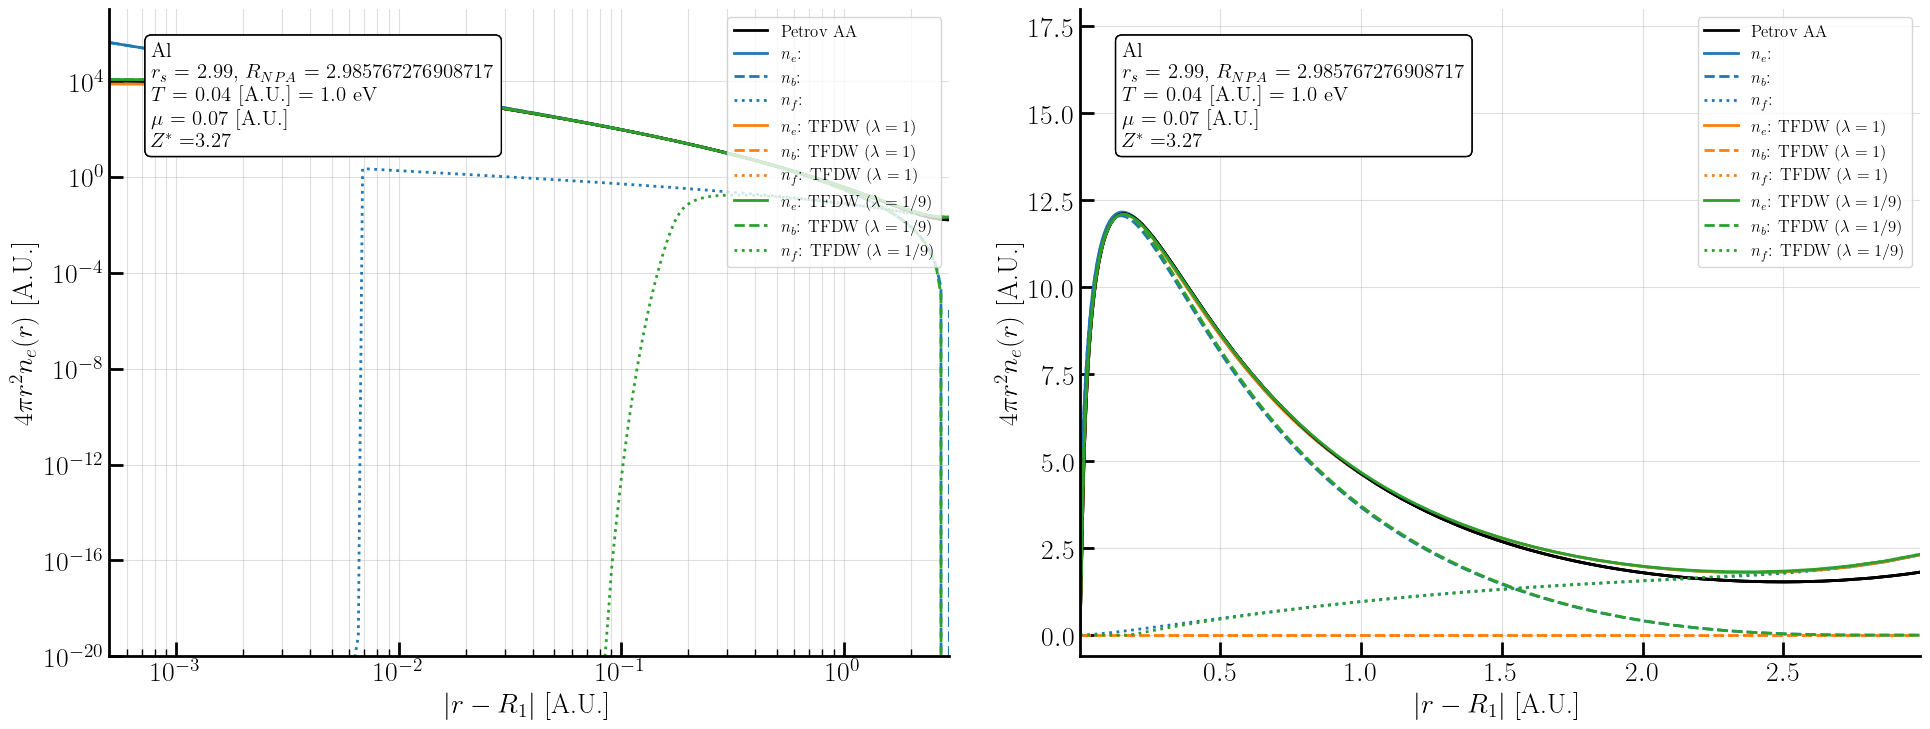

In [51]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def make_plot_bound_free(aa, axs=None, name='', color=colors[0]):
    eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
    if axs is None:
        fig, axs = plt.subplots(ncols=2,figsize=(20,8),facecolor='w')

    # Density * 4pi r^2 plot
    axs[0].plot(aa.petrov.r_data, aa.petrov.rho_data + aa.petrov.rho_0, 'k-', label="Petrov AA")
    axs[0].plot(aa.grid.xs, aa.ne ,'-',color=color, label=r'$n_e$: '+ name)
    axs[0].plot(aa.grid.xs, aa.n_b,'--',color=color,  label=r'$n_b$: ' + name)
    axs[0].plot(aa.grid.xs, aa.n_f,':',color=color,  label=r'$n_f$: ' + name)


    axs[0].set_ylabel(r'$4 \pi r^2 n_e(r) $ [A.U.]',fontsize=20)
    axs[0].set_ylim(1e-20, 1e7)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')

    
    # Density * 4pi r^2 plot
    factor = 4*np.pi*aa.grid.xs**2
    axs[1].plot(aa.petrov.r_data, 4*np.pi*aa.petrov.r_data**2*(aa.petrov.rho_data + aa.petrov.rho_0), 'k-', label="Petrov AA")
    axs[1].plot(aa.grid.xs, aa.ne*factor ,'-',color=color, label=r'$n_e$: '+ name)
    axs[1].plot(aa.grid.xs, aa.n_b*factor,'--',color=color,  label=r'$n_b$: ' + name)
    axs[1].plot(aa.grid.xs, aa.n_f*factor,':',color=color,  label=r'$n_f$: ' + name)


    axs[1].set_ylabel(r'$4 \pi r^2 n_e(r) $ [A.U.]',fontsize=20)
    axs[1].set_ylim(None, 18)

        
    for ax in axs:
        ax.set_xlim(aa.grid.xs[0],aa.grid.xs[-1])
        ax.set_xlabel(r'$|r-R_1|$ [A.U.]',fontsize=20)
        ax.legend(loc="upper right",fontsize=20,labelspacing = 0.1)
        ax.tick_params(labelsize=20)
        ax.grid(which='both',alpha=0.4)

        # make textbox
        text = ("{0}\n".format(aa.name)+ 
            r"$r_s$ = " + "{0},    ".format(np.round(aa.rs,2)) +
            r"$R_{NPA}$ = " + "{0}\n".format(aa.R)  +
                r"$T$ = " + "{0} [A.U.] = {1} eV\n".format(np.round(aa.T,2),np.round(aa.T/eV,2)) + r"$\mu$ = " + "{0} [A.U.]\n".format(np.round(aa.μ,2)) +
                r"$Z^\ast = $" + "{0}".format(np.round(aa.Zstar,2))  )

        props = dict(boxstyle='round', facecolor='w')
        ax.text(0.05,0.95, text, fontsize=15, transform=ax.transAxes, verticalalignment='top', bbox=props)

    plt.tight_layout()
    name = "NPA_densities_{0}_rs{1}_{2}eV_R{3}.png".format(aa.name, np.round(aa.rs,2), np.round(aa.T/eV,2) ,np.round(aa.R))
    plt.savefig("/home/zach/plasma/atomic_forces/average_atom/media/" + name, dpi=300, bbox_inches='tight',facecolor="w")
    
    
    return axs


axs = make_plot_bound_free(aa_tfd, color=colors[0])
make_plot_bound_free(aa_tfdw_λ1, color=colors[1], axs=axs, name=r'TFDW $(\lambda=1)$')
make_plot_bound_free(aa_tfdw_λover9, color=colors[2], axs=axs, name=r'TFDW $(\lambda=1/9)$')
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper right')
# axs[1].set_ylim(1e-5,1e3)

In [15]:
def make_φpseudo(aa):
    nf = aa.n_f
    aa.n_f = np.where(aa.n_f<=1e-30, 1e-30, aa.n_f)
        
    etas = aa.TF.η_interp(nf) # η = β( μ + self.φe + self.φion - self.vxc_f(ne)  )         
    totφ_pseudo = etas*aa.T + aa.vxc_f(nf ) - aa.μ # total potential that must be acting on nf
    φe_from_nf, _ = aa.get_φe( -nf ) # potential from nf itself
    φ_pseudo = (totφ_pseudo - φe_from_nf)
    φ_pseudo = φ_pseudo + aa.Zstar/aa.rs #- φ_pseudo[-1] # residual is just potential (and μ) from the ion and bound states
    return φ_pseudo

φ_pseudo_TFD = make_φpseudo(aa_tfd)
# φ_pseudo_TFDW_λ1 = make_φpseudo(aa_tfdw_λ1)
φ_pseudo_TFDW_λover9 = make_φpseudo(aa_tfdw_λover9)

In [19]:
# aa_tfd.make_plots();
# aa_tfdw_λover9.make_plots();
# aa_tfdw_λ1.make_plots();

(0.01, 4)

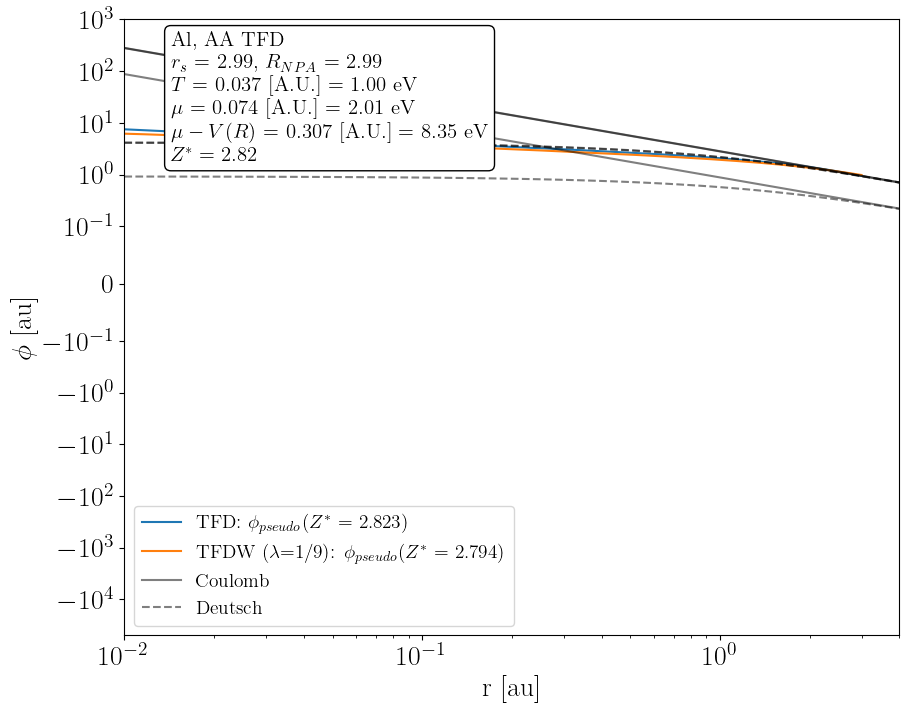

In [20]:
from hnc.hnc.qsps import Quantum_Statistical_Potentials as QSP
from hnc.hnc.misc import n_from_rs

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(aa_tfd.grid.xs, φ_pseudo_TFD , '-', label=r'TFD: $\phi_{{pseudo}} (Z^*$ = {0:.3f})'.format(aa_tfd.Zstar))
# ax.plot(aa_tfd.grid.xs, φ_pseudo_TFDW_λ1 , '-', label=r'TFDW ($\lambda$=1): $\phi_{{pseudo}} (Z^*$ = {0:.3f})'.format(aa_tfdw_λ1.Zstar))
ax.plot(aa_tfd.grid.xs, φ_pseudo_TFDW_λover9 , '-', label=r'TFDW ($\lambda$=1/9): $\phi_{{pseudo}} (Z^*$ = {0:.3f})'.format(aa_tfdw_λover9.Zstar))

dense_xs = np.geomspace(1e-2,1e1, num=100)
for i, aa in enumerate([aa_tfd, aa_tfdw_λ1, aa_tfdw_λover9]):
    qsp = QSP(aa.Z, aa.A, aa.Zstar, aa.T, aa.T, aa.rs, aa.Zstar*n_from_rs(aa.rs), which_Tij='thermal')
    if i==0:
        ax.plot(dense_xs, aa.Zstar/dense_xs,'k', label=f'Coulomb' ,alpha=0.5)
        ax.plot(dense_xs, -qsp.Tie_c*qsp.βv_Deutsch(qsp.Γei, dense_xs/aa.rs, qsp.Λei),'k--', label='Deutsch', alpha=0.5)
    else:
        ax.plot(dense_xs, aa.Zstar/dense_xs,'k',alpha=0.5)
        ax.plot(dense_xs, -qsp.Tie_c*qsp.βv_Deutsch(qsp.Γei, dense_xs/aa.rs, qsp.Λei),'k--', alpha=0.5)

# Text box for information			
props = dict(boxstyle='round', facecolor='w')
ax.text(0.06,0.98, aa_tfd.nice_text, fontsize=15, transform=ax.transAxes, verticalalignment='top', bbox=props)

ax.legend(fontsize=16)
# ax.set_ylim(1e-1, 1e3)
ax.set_ylim(-5e4, 1e3)
ax.set_yscale('symlog',linthresh=0.1)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=20)
ax.set_xlabel("r [au]", fontsize=20)
ax.set_ylabel(r"$\phi$ [au]", fontsize=20)
ax.legend(fontsize=14)
ax.set_xlim(1e-2, 4)

#### TF Integral Error at low $n_f$ fix

In [21]:
def get_min_xi_φ(φ):
    abs_grads = np.abs(np.gradient(φ))
    large_grad_spot = np.argmax(abs_grads) 
    max_grad = abs_grads[large_grad_spot]
    if max_grad>1e10: 
        print(f"Fixing large grad of {max_grad:0.3e}")
        return large_grad_spot+1
    else:
        return 0
TFD_xi_min = get_min_xi_φ(φ_pseudo_TFD)
# TFDW_λover9_xi_min = get_min_xi_φ(φ_pseudo_TFDW_λover9)
# TFDW_λ1_xi_min = get_min_xi_φ(φ_pseudo_TFDW_λ1)

## Linear Response

In [22]:
from atomic_forces.average_atom.python.linear_response import response

In [23]:
from copy import deepcopy
aa_lin_response = deepcopy(aa_tfdw_λover9)

-0.015429233056910832


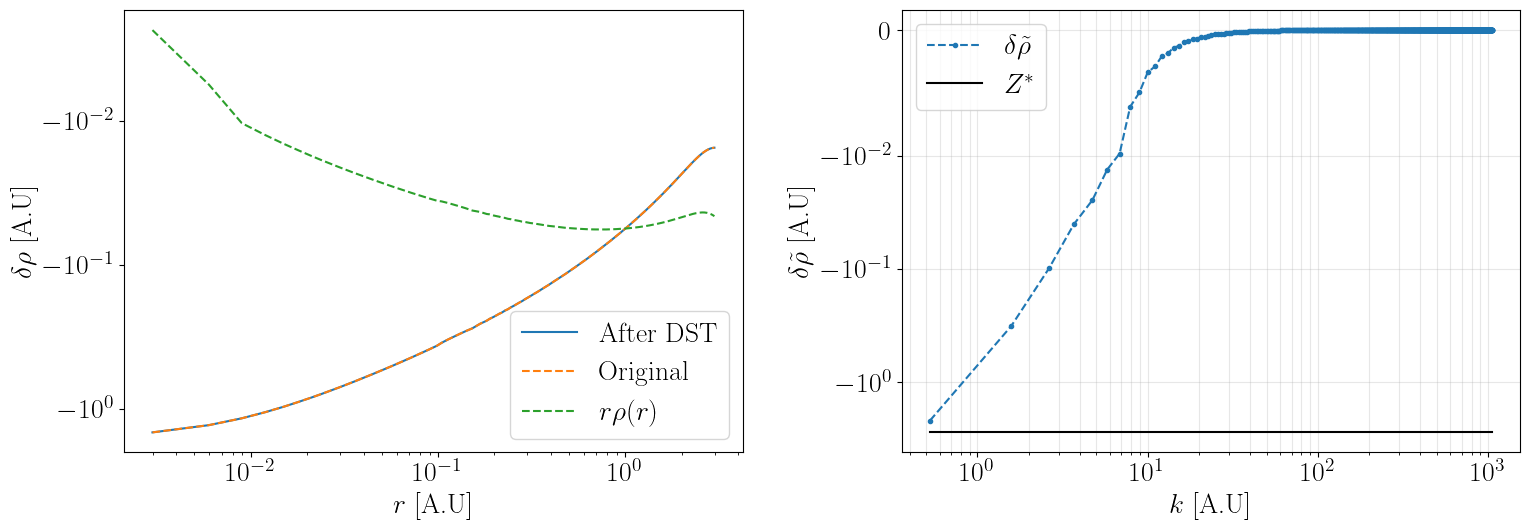

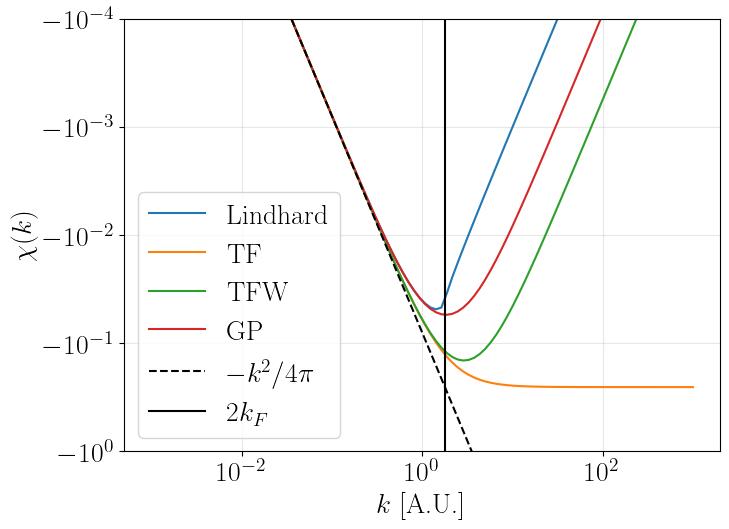

In [24]:
aa_lin_response.δn_f = aa_lin_response.n_f.copy()
χtype='TFW'
lin = response(aa_lin_response, dst_type=3,N=1000,ρtype='data',χtype=χtype,linear_type='standard')
lin.check_ρ()
lin.compare_χs()

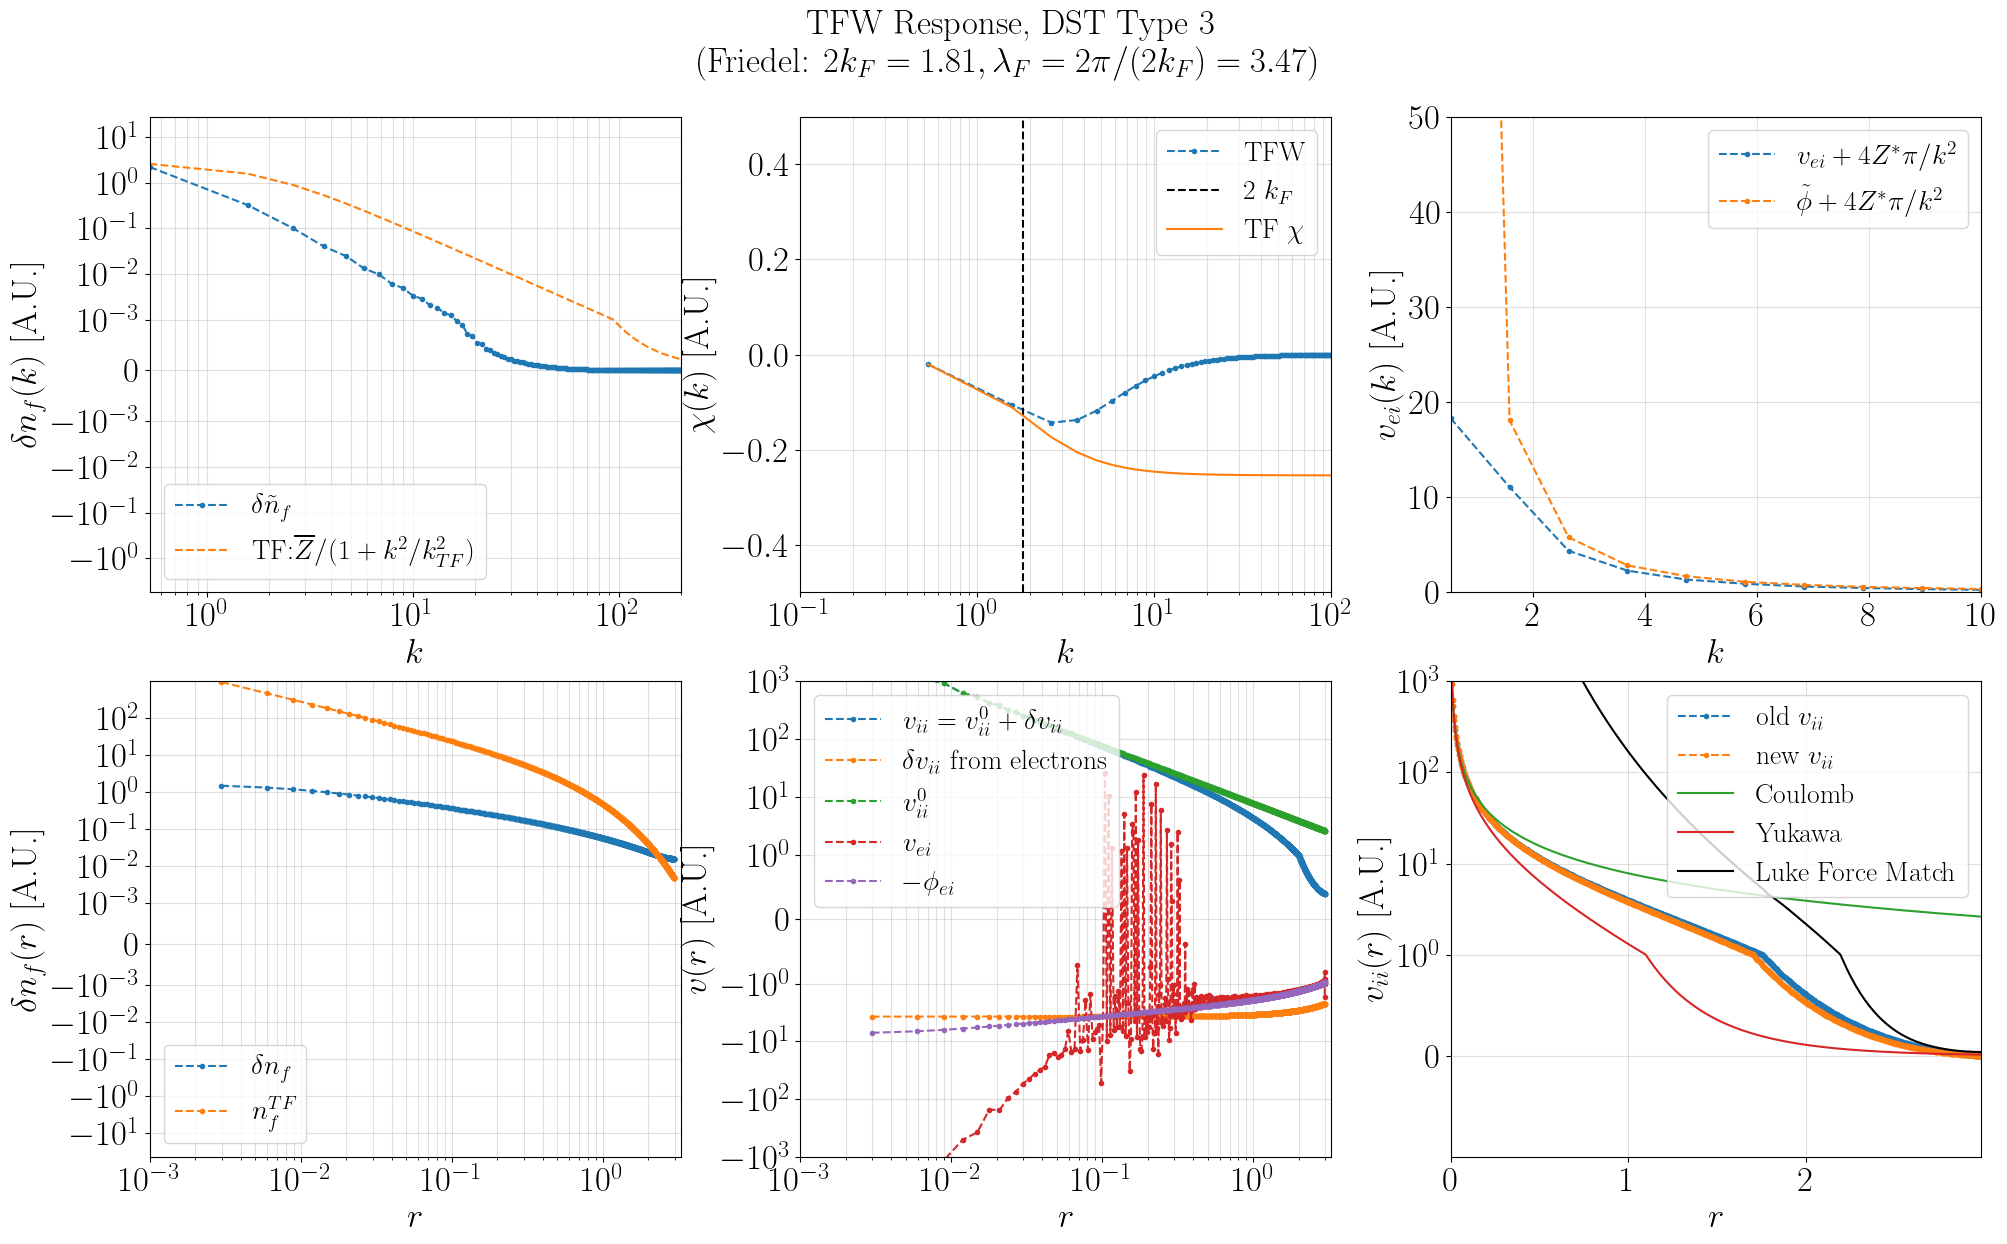

In [25]:
atom = aa_lin_response
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq, dst, idst
from scipy.interpolate import interp1d

rlist_luke, Vlist_luke, Flist_luke= np.genfromtxt("/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR",delimiter='',skip_header=5)[:,1:].T

def ifft(f_tilde):
    return 2*lin.N *1/(2*π)**3*0.5*(π/lin.R)*idst(4*π*lin.k_list*f_tilde ,type=lin.dst_type)/lin.r_list

def plot_linear_response(check_GP=True):
    
    φ_func =  interp1d(lin.atom.grid.xs, φ_pseudo_TFDW_λover9, bounds_error = False, fill_value = (φ_pseudo_TFD[0], φ_pseudo_TFD[-1]) )#'extrapolate')
    # δnf_func  =  lambda r: nf_func(r) - nf[-1]# - n0 # Free change from uniformity
    φ =  φ_func(lin.r_list)
    φ_tilde =  0.5*lin.dr*dst(4*np.pi* lin.r_list* φ,type=lin.dst_type)/lin.k_list
    
    fig = plt.figure(figsize=(20,12),facecolor="w")
    gs = fig.add_gridspec(2,3)
    
    ax1=fig.add_subplot(gs[0,0])
    ax2=fig.add_subplot(gs[0,1])
    ax3=fig.add_subplot(gs[0,2])
    ax4=fig.add_subplot(gs[1,0])
    ax5=fig.add_subplot(gs[1,1])
    ax6=fig.add_subplot(gs[1,2])
    
    Zstar, kTF, EF = atom.Zstar, lin.kTF, lin.EF
    fig.suptitle("{0} Response, DST Type {1}\n".format(χtype, lin.dst_type) + 
                 r"(Friedel: $2 k_F={0}, \lambda_F= 2\pi/(2k_F) ={1})$".format(np.round(2*lin.kF,2),np.round(π/lin.kF,2)  ),y=1.02,fontsize=25)
    
    ### Plot 1 ###
    k_list, r_list = lin.k_list, lin.r_list
    ax1.plot(lin.k_list,lin.δnf_tilde,'--.',label=r'$\delta \tilde{n}_f$')
    ax1.plot(k_list,Zstar/(1+k_list**2/kTF**2),'--',label='TF:$\overline{Z}/(1+k^2/k^2_{TF})$')
    ax1.set_ylabel(r'$\delta n_f(k)$ [A.U.]',fontsize=25)
    
    
    ### Plot 2 ###
    ax2.plot(lin.k_list, lin.χs,'--.',label=χtype)
    #ax1.plot(lin.k_list, k_list**2/(4*π)* kTF**2/(kTF**2 + k_list**2) ,'--',label='TF')
    kF = ((2*EF)**(1/2))
    ax2.axvline(x = 2*kF, color = 'k',linestyle='--', label = r'2 $k_F$')
    ax2.plot(lin.k_list, -lin.k_list**2/(4*π) * 1/(1+lin.k_list**2/lin.kTF**2),label=r"TF $\chi$")
    ax2.set_ylabel(r'$\chi(k)$ [A.U.]',fontsize=25)
    
    
    ### Plot 3 ###
    # ax3.plot(vei_Carter.T[0],vei_Carter.T[1], 'k-', label='Carter + Huang')
    ax3.plot(lin.k_list, lin.vei_tilde + 4*π*Zstar/lin.k_list**2 ,'--.',label=r"$v_{ei} + 4 Z^* \pi/k^2$")
    ax3.plot(lin.k_list, φ_tilde + 4*π*Zstar/lin.k_list**2 ,'--.',label=r"$\tilde{\phi} + 4 Z^* \pi/k^2$")
    #     ax3.plot(lin.k_list,lin.vei_tilde,'--.',label=r"$v_{ei}$")
#     ax3.plot(lin.k_list,-4*π*Zstar/lin.k_list**2,'--',label='Coulomb')
    ax3.set_ylabel(r'$v_{ei}(k) $ [A.U.]',fontsize=25)
    
    ### Bottom Row###
    ### Plot 4 ###
    ax4.plot(lin.r_list, lin.δnf ,'--.',label=r'$\delta n_f$ ')
    ax4.plot(lin.r_list, Zstar/lin.r_list * np.exp(-lin.r_list*lin.kTF) ,'--.',label=r'$n_f^{TF}$ ')
    ax4.set_ylabel(r'$\delta n_f(r)$ [A.U.]',fontsize=25)
    
    ### Plot 5 ###
    ax5.plot(lin.r_list, lin.vii, '--.', label=r'$v_{ii}= v^0_{ii} + \delta v_{ii}$')
    ax5.plot(lin.r_list, lin.δvii,'--.', label=r'$\delta v_{ii}$ from electrons')
    ax5.plot(lin.r_list, lin.vii0,'--.', label=r'$v^0_{ii}$')
    ax5.plot(lin.r_list, lin.vei, '--.', label=r'$v_{ei}$ ')#δvii_tilde(ks),'--')
    ax5.plot(lin.r_list, -φ, '--.', label=r'$-\phi_{ei}$ ')#δvii_tilde(ks),'--')
    ax5.set_ylabel(r'$v(r)$ [A.U.]',fontsize=25)
    
    if check_GP:
        ax1.plot(GP_kdata['k'], -GP_kdata['χ(k)'],label="GP Comparison")
        ax2.plot(GP_kdata['k'],GP_kdata['ne(k)'],label="GP Comparison")
        ax3.plot(GP_kdata['k'], -GP_kdata['Vei(k)'],label="GP Comparison")
    
    ### Plot 6 ###
    ax6.plot(lin.r_list, lin.vii - lin.vii[-1],'--.',label=r"old $v_{ii}$")
                    
    new_vii = ifft(lin.vii0_tilde + lin.χs * φ_tilde**2)
    ax6.plot(lin.r_list, new_vii-new_vii[-1] ,'--.',label=r"new $v_{ii}$")
    ax6.plot(lin.r_list, [Zstar**2/r for r in lin.r_list],linestyle='-',label='Coulomb')
    ax6.plot(lin.r_list, [Zstar**2/r * np.exp(-lin.kTF*r) for r in r_list],linestyle='-',label='Yukawa')
    ax6.plot(rlist_luke, Vlist_luke,'k-',label="Luke Force Match")
    
    ax6.set_ylabel(r'$v_{ii}(r)$ [A.U.]',fontsize=25)
    
    
    for ax in [ax1,ax2,ax3]:
        ax.set_xlabel(r'$k$',fontsize=25)

    for ax in [ax4,ax5,ax6]:
        ax.set_xlabel(r'$r$',fontsize=25)
        ax.set_xscale('log')    
        #ax.set_yscale('log') 
        ax.set_xlim(1e-3,1.1*lin.R)
        
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.grid(which='both', alpha=0.4)
        ax.tick_params(labelsize=25)
        ax.legend(fontsize=20)
    
        
    ax1.set_xscale('log')
    ax1.set_ylim(-2*Zstar,10*Zstar)
    ax1.set_yscale('symlog',linthresh=1e-3)
    ax1.set_xlim(np.min(k_list),2e2)
    
    ax2.set_xscale('log')
    ax2.set_xlim(1e-1,1e2)
    ax2.set_ylim(-0.5,0.5)
    
#     ax3.set_xscale('log')
    ax3.set_ylim(0,50)
#     ax3.set_yscale('symlog',linthresh=25)
    ax3.set_xlim(np.min(k_list),10)
   

    ax4.set_yscale('symlog',linthresh=1e-3)
    ax4.set_xscale('log')
    ax4.set_xlim(1e-3,1.1*lin.R)


    ax5.set_yscale('symlog',linthresh=1)
    ax6.set_yscale('symlog',linthresh=1)
    ax5.set_ylim(-1e3,1e3)
    ax6.set_ylim(-1,1e3)
    
    ax6.set_xscale('linear')
    ax6.set_xlim(0,lin.R)
    
    
    plt.tight_layout(pad=0)
    plt.savefig("../media/{0}-linear_response_GPfit_type{1}.png".format(χtype,lin.dst_type),bbox_inches='tight')


plot_linear_response(check_GP=False)

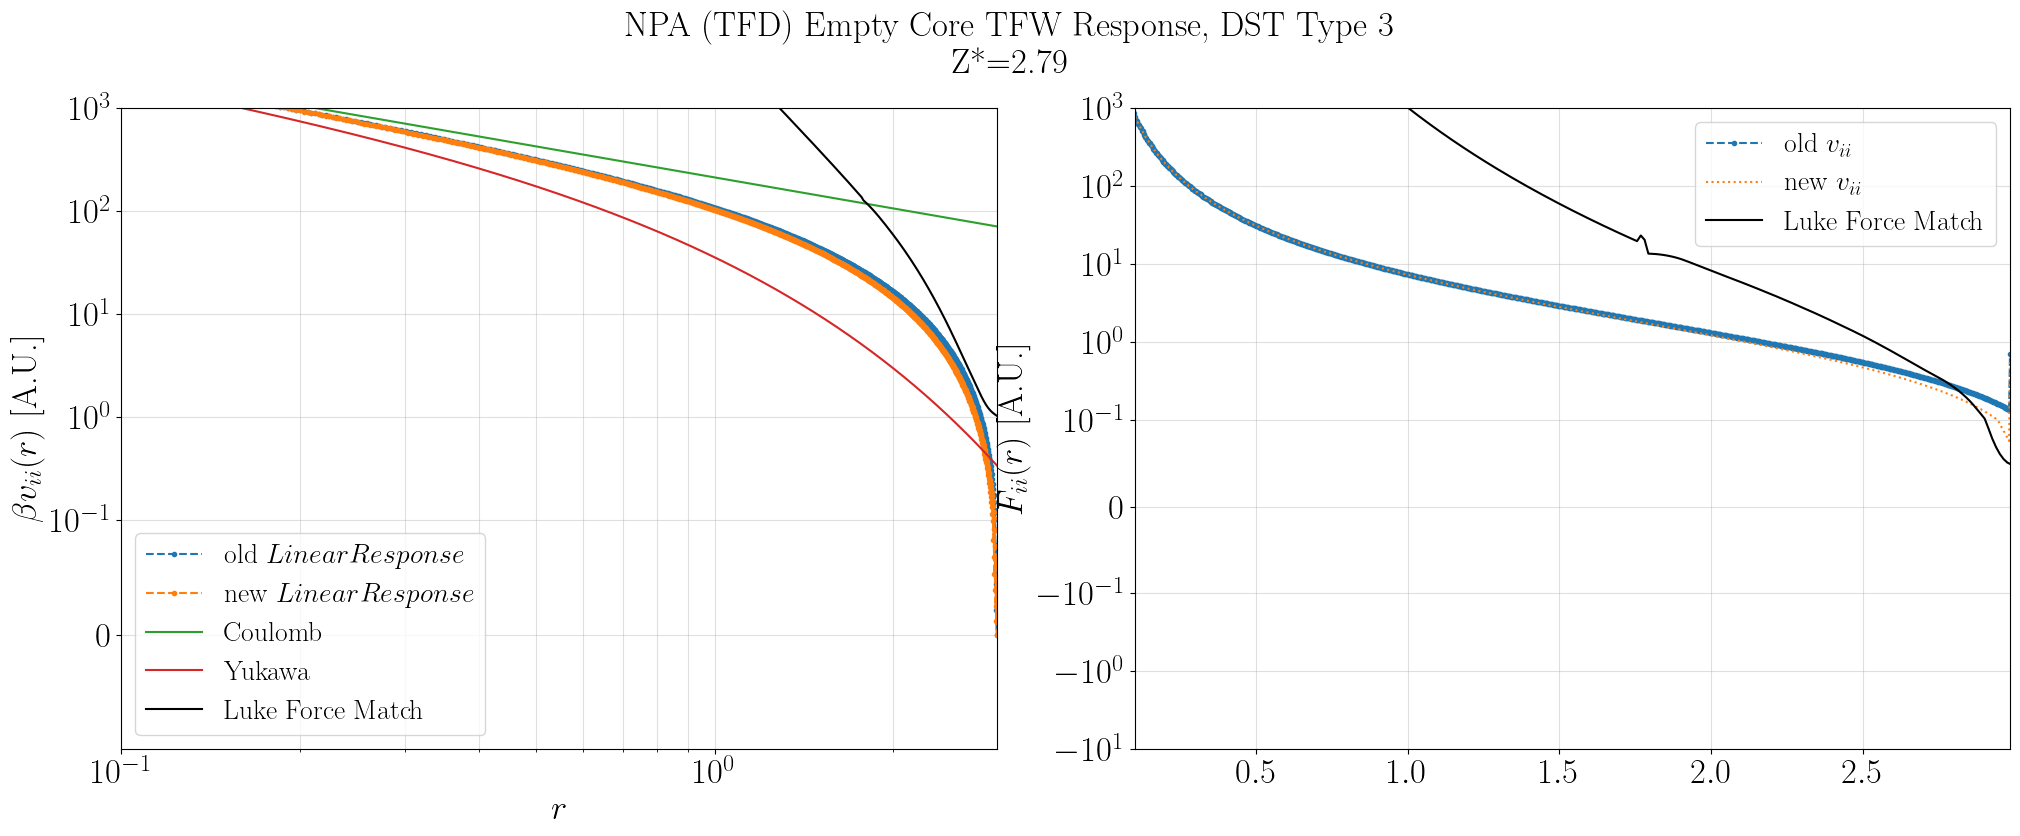

In [26]:
def plot_linear_response(check_GP=True):
    fig = plt.figure(figsize=(20,8),facecolor="w")
    gs = fig.add_gridspec(1,2)
    
    ax1=fig.add_subplot(gs[0,0])
    ax2=fig.add_subplot(gs[0,1])
    
    Zstar, kTF, EF = atom.Zstar, lin.kTF, lin.EF
#     fig.suptitle("{0} Response, DST Type {1}\n".format(χtype, lin.dst_type) + 
#                  r"(Friedel: $2 k_F={0}, \lambda_F= 2\pi/(2k_F) ={1})$".format(np.round(2*lin.kF,2),np.round(π/lin.kF,2)  ),y=1.02,fontsize=25)
    fig.suptitle("NPA (TFD) Empty Core {0} Response, DST Type {1}\n".format(χtype, lin.dst_type) + 
                 "Z*={0:.2f}".format(atom.Zstar),y=1.02,fontsize=25)
#     fig.suptitle("NPA (TFD) HNC, {0} Response, DST Type {1}\n".format(χtype, lin.dst_type) + 
#                  "Z*={0:.2f}".format(atom.Zstar),y=1.02,fontsize=25)
    
    k_list, r_list = lin.k_list, lin.r_list

    ### Plot 1 ###
    φ_func =  interp1d(lin.atom.grid.xs, φ_pseudo_TFDW_λover9, bounds_error = False, fill_value = (φ_pseudo_TFD[0], φ_pseudo_TFD[-1]) )#'extrapolate')
    # δnf_func  =  lambda r: nf_func(r) - nf[-1]# - n0 # Free change from uniformity
    φ =  φ_func(lin.r_list)
    φ_tilde =  0.5*lin.dr*dst(4*np.pi* lin.r_list* φ,type=lin.dst_type)/lin.k_list
        
    new_vii = ifft(lin.vii0_tilde + lin.χs * φ_tilde**2)
    ax1.plot(lin.r_list, (lin.vii-lin.vii[-1])/atom.T ,'--.',label=r"old $Linear Response$")
    ax1.plot(lin.r_list, (new_vii-new_vii[-1])/atom.T,'--.',label=r"new $Linear Response$")
    ax1.plot(lin.r_list, np.array([Zstar**2/r for r in lin.r_list])/atom.T,linestyle='-',label='Coulomb')
    ax1.plot(lin.r_list, np.array([Zstar**2/r * np.exp(-lin.kTF*r) for r in r_list])/atom.T,linestyle='-',label='Yukawa')
    ax1.plot(rlist_luke, Vlist_luke/atom.T,'k-',label="Luke Force Match")
    
    ax1.set_ylabel(r'$\beta v_{ii}(r)$ [A.U.]',fontsize=25)
    
    ## Plot 2 ###

    ax2.plot(lin.r_list, -np.gradient(lin.vii, lin.r_list),'--.',label=r"old $v_{ii}$")
    ax2.plot(lin.r_list, -np.gradient(new_vii, lin.r_list),':',label=r"new $v_{ii}$")
#     ax2.plot(lin.r_list[:-1], [Zstar**2/r for r in lin.r_list],linestyle='-',label='Coulomb')
#     ax2.plot(lin.r_list[:-1], [Zstar**2/r * np.exp(-lin.kTF*r) for r in r_list],linestyle='-',label='Yukawa')
    ax2.plot(rlist_luke, Flist_luke,'k-',label="Luke Force Match")
    
    ax2.set_ylabel(r'$F_{ii}(r)$ [A.U.]',fontsize=25)
    
    
    for ax in [ax1]:
        ax.set_xlabel(r'$r$',fontsize=25)
        ax.set_xscale('log')    
        #ax.set_yscale('log') 
        
    for ax in [ax1,ax2]:
        ax.grid(which='both', alpha=0.4)
        ax.tick_params(labelsize=25)
        ax.legend(fontsize=20)
    
    
    ax1.set_yscale('symlog',linthresh=1e-1)
    ax1.set_ylim(-1e-1,1e3)
    ax2.set_yscale('symlog',linthresh=1e-1)
    ax2.set_ylim(-1e1,1e3)
    
    ax1.set_xscale('log')
    ax1.set_xlim(1e-1,lin.R)
    # ax2.set_xscale('log')
    ax2.set_xlim(1e-1,lin.R)
    
    
    plt.tight_layout(pad=0)
#     plt.savefig("../media/{0}-linear_response_GPfit_type{1}.png".format(χtype,lin.dst_type),bbox_inches='tight')


plot_linear_response(check_GP=False)

# HNC

In [27]:
from hnc.hnc.misc import n_from_rs, Fermi_Energy
def Debye_length(T, ni, Zbar):
    ne = Zbar*ni
    EF = Fermi_Energy(ne)
    T_effective = (T**1.8 + (2/3*EF)**1.8)**(1/1.8)
    λD = 1/np.sqrt(  4*π*ne/T_effective ) # Including degeneracy
    # λD = 1/np.sqrt(  4*π*ne/T_effective + 4*π*Zbar**2*ni/T  )  # Including ions
    return λD

def Kappa(T, ni, Zbar):
    rs = rs_from_n(ni)
    λD = Debye_length(T, ni, Zbar)
    return rs/λD

In [28]:
from atomic_forces.average_atom.python.linear_response import response
from copy import deepcopy
from hnc.hnc.hnc import Integral_Equation_Solver
from hnc.hnc.misc import rs_from_n, n_from_rs
from scipy.interpolate import interp1d

# Define model using
aa_model, φ_pseudo = deepcopy(aa_tfdw_λover9), φ_pseudo_TFDW_λover9 
# aa_model, φ_pseudo = deepcopy(aa_tfdw_λ1), φ_pseudo_TFDW_λ1 
# aa_model, φ_pseudo = deepcopy(aa_tfd), φ_pseudo_TFD 
good_indices = np.where(aa_model.n_f>1e-8) # Correcting issue with fact that fermi integral fails when n_f/n_b << 1
aa_model.grid.xs_fix = aa_model.grid.xs[good_indices]
φ_pseudo = φ_pseudo[good_indices]

φ_pseudo = φ_pseudo + ( aa_model.Zstar/aa_model.grid.xs_fix[-1] - φ_pseudo[-1] ) 
interp_φ = interp1d(aa_model.grid.xs_fix, φ_pseudo  )

@np.vectorize
def get_φ(r):
    if r<aa_model.grid.xs_fix[0]:
        return φ_pseudo[0]
    elif r>aa_model.grid.xs[-1]:
        return aa_model.Zstar/r
    else:
        return interp_φ(r)

# Linear Response package

aa_model.δn_f = aa_model.n_f.copy()
# χtype='TFW'
lin = response(aa_model, dst_type=3,N=1000,ρtype='data',linear_type='standard')

Γ = aa_model.Zstar**2/(aa_model.T*rs)
κ = Kappa(aa_model.T, n_from_rs(rs), aa_model.Zstar)

# HNC package
hnc = Integral_Equation_Solver(1, Γ, 3/(4*π), T_AU, m_p*A, dst_type=3, h_max=1e3, oz_method='standard',
        kappa = κ, kappa_multiscale = 1.0,  R_max=20.0, N_bins=5000, names=None, closure='hnc')

hnc_lin = Integral_Equation_Solver(1, Γ, 3/(4*π), T_AU, m_p*A, dst_type=3, h_max=1e3, oz_method='standard',
        kappa = κ, kappa_multiscale = 1.0,  R_max=20.0, N_bins=5000, names=None, closure='hnc')

hnc_Y = Integral_Equation_Solver(1, Γ, 3/(4*π), T_AU, m_p*A, dst_type=3, h_max=1e3, oz_method='standard',
        kappa = κ, kappa_multiscale = 1.0,  R_max=20.0, N_bins=5000, names=None, closure='hnc')

hnc_C = Integral_Equation_Solver(1, Γ, 3/(4*π), T_AU, m_p*A, dst_type=3, h_max=1e3, oz_method='standard',
        kappa = κ, kappa_multiscale = 1.0,  R_max=20.0, N_bins=5000, names=None, closure='hnc')


# Non-linear response method
# χ = lin.χ_Lindhard(hnc.k_array/rs) 
χ = lin.χ_Lindhard(hnc.k_array/rs) 

u_k_Y_approx = 4*π*aa_model.Zstar**2/(  (hnc.k_array/rs)**2 + κ**2)

u_k_matrix = np.array([[  4*π*aa_model.Zstar**2/(hnc.k_array/rs)**2 + χ*rs**6*hnc.FT_r_2_k(get_φ(hnc.r_array*rs) )**2 - u_k_Y_approx]])
# u_k_matrix = rs**4*-np.array([[ χ*hnc.FT_r_2_k(get_φ(hnc.r_array*rs) )**2]])
βu_k_matrix = (1/aa_model.T)*u_k_matrix
βu_r_matrix = hnc.FT_k_2_r(rs**-3*βu_k_matrix) + (1/aa_model.T)*aa_model.Zstar**2/(hnc.r_array*rs)*np.exp(-κ*hnc.r_array)

hnc.set_βu_matrix(βu_r_matrix)

# linera response method

# u_k_matrix = np.array([[  4*π*aa_model.Zstar**2/(hnc.k_array/rs)**2 + 1/χ*rs**6*hnc.FT_r_2_k(get_φ(hnc.r_array*rs) )**2 - u_k_Y_approx]])
# # u_k_matrix = rs**4*-np.array([[ χ*hnc.FT_r_2_k(get_φ(hnc.r_array*rs) )**2]])
# βu_k_matrix = (1/aa_model.T)*u_k_matrix
# βu_r_matrix = hnc.FT_k_2_r(rs**-3*βu_k_matrix) + (1/aa_model.T)*aa_model.Zstar**2/(hnc.r_array*rs)*np.exp(-κ*hnc.r_array)

# hnc.set_βu_matrix(βu_r_matrix)

# hnc_lin.

# Make OCP
hnc_C.set_βu_matrix(np.array([[ hnc_C.Γ_matrix[0,0]/hnc_C.r_array]])) 
hnc_C.initialize_c_k()
hnc_C.set_C_matrix()

#Add all Bridge functions
B_OCP = hnc.Bridge_function_OCP(hnc.r_array, Γ)
B_YOCP = hnc.Bridge_function_Yukawa(hnc.r_array, Γ, κ)
B_OCP_matrix = np.array([[B_OCP]]) # to add to βu_r_matrix
B_YOCP_matrix = np.array([[B_YOCP]]) # to add to βu_r_matrix

hnc.set_βu_matrix(hnc.βu_r_matrix - B_YOCP_matrix)
hnc_Y.set_βu_matrix(hnc_Y.βu_r_matrix - B_YOCP_matrix)
hnc_C.set_βu_matrix(hnc_C.βu_r_matrix - B_OCP_matrix)

In [36]:
np.array([hnc.r_array*rs, aa_model.T*hnc.βu_r_matrix[0,0]]).T

array([[1.19430691e-02, 6.66530905e+02],
       [2.38861382e-02, 3.39266949e+02],
       [3.58292073e-02, 2.29932649e+02],
       ...,
       [5.96914594e+01, 1.34664751e-07],
       [5.97034025e+01, 1.37162468e-07],
       [5.97153455e+01, 1.34729196e-07]])

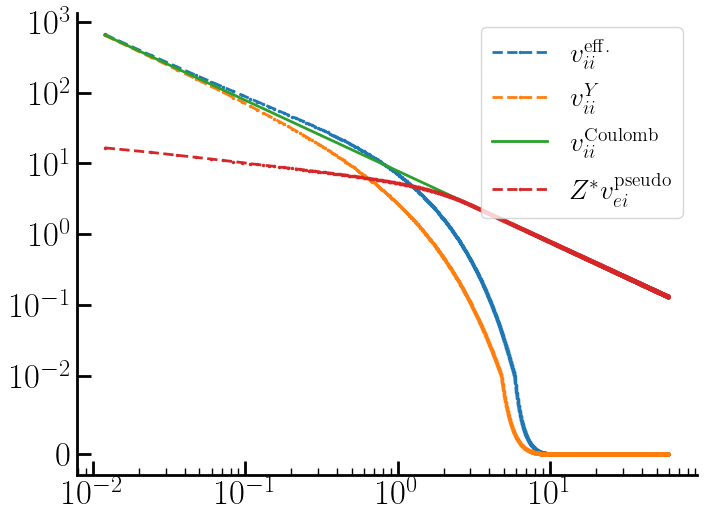

In [38]:
fig,ax = plt.subplots()#figsize=(8,6))

plt.style.use('~/plasma/Nice_plt_stylesheet.mplstyle')

# ax.plot(hnc.r_array*rs, hnc.FT_k_2_r(rs**-3*u_k_Y_approx))

# ax.plot(hnc.r_array*rs, aa_model.Zstar**2/(hnc.r_array*rs)*np.exp(-κ*hnc.r_array))
ax.plot(hnc.r_array*rs, aa_model.T*hnc.βu_r_matrix[0,0],'--.',label=r'$v_{ii}^{\rm eff.}$')
ax.plot(hnc.r_array*rs, aa_model.T*hnc.βu_Yukawa[0,0],'--.',label=r'$v_{ii}^{Y}$')
# ax.plot(hnc.r_array*rs, aa_model.Zstar**2/(hnc.r_array*rs), label='')
ax.plot(hnc.r_array*rs, aa_model.T*(hnc.Γ_matrix[0,0]/hnc.r_array) ,label=r'$v_{ii}^{\rm Coulomb}$')
ax.plot(hnc.r_array*rs, aa_model.Zstar*get_φ(hnc.r_array*rs),'--.', label=r"$Z^* v^{\rm pseudo}_{ei} $")

ax.set_yscale('symlog',linthresh=0.01)
ax.set_xscale('log')
ax.legend()



In [39]:
aa_model.Zstar

2.79411999474721

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


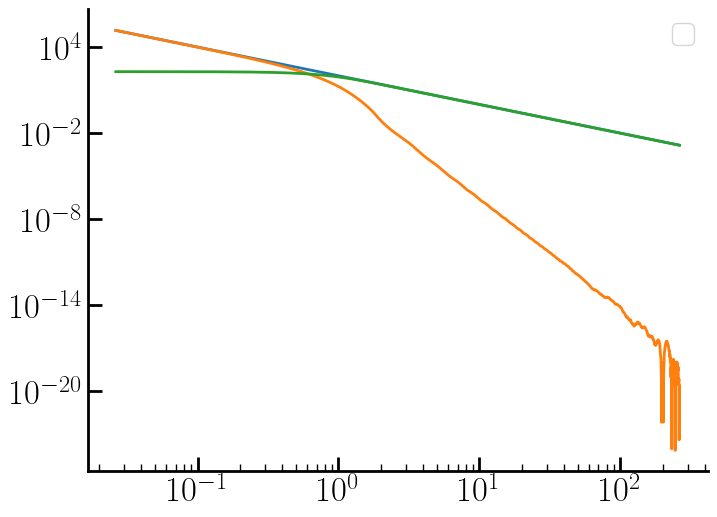

In [30]:
fig,ax = plt.subplots(figsize=(8,6))

# plt.style.use('~/plasma/Nice_plt_stylesheet.mplstyle')

# ax.plot(hnc.k_array/rs,  -χ,'--.')
# ax.plot(hnc.k_array, rs**3*hnc.FT_r_2_k(get_φ(hnc.r_array*rs)))
# ax.plot(hnc.k_array/rs, rs**3*hnc.FT_r_2_k(aa_model.Zstar**2/(hnc.r_array*rs)))
ax.plot(hnc.k_array/rs, 4*π*aa_model.Zstar**2/(hnc.k_array/rs)**2)
# ax.plot(hnc.k_array/rs, u_k_matrix[0,0])
# ax.plot(hnc.k_array/rs,  4*π*aa_model.Zstar**2/(hnc.k_array)**2)
ax.plot(hnc.k_array/rs, -χ*rs**6*hnc.FT_r_2_k(get_φ(hnc.r_array*rs) )**2)

ax.plot(hnc.k_array/rs, 4*π*aa_model.Zstar**2/(hnc.k_array/rs)**2 + χ*rs**6*hnc.FT_r_2_k(get_φ(hnc.r_array*rs) )**2)

# ax.plot(hnc.r_array*rs, get_φ(hnc.r_array*rs),'--')
# ax.plot(aa_model.grid.xs_fix, φ_pseudo,'--.')
# ax.plot(hnc.r_array, (hnc.Γ_matrix[0,0]/hnc.r_array) )

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1e-4, 10)
ax.legend()

#### Solve

In [31]:
hnc.HNC_solve(alpha_Picard=1e-2, iters_to_wait=100000, num_iterations=100000 )
hnc_Y.HNC_solve(alpha_Picard=1e-2, iters_to_wait=10000, num_iterations=10000 )
hnc_C.HNC_solve(alpha_Picard=1e-1,iters_to_wait=10000, num_iterations=10000 )

0: Initial condition Total Error: 2.881e+02
Exiting status 0, reverting to best index so far: 16749
Final iter:16750, Total Error: 9.994e-07
0: Initial condition Total Error: 2.834e+02
Exiting status 0, reverting to best index so far: 6841
Final iter:6842, Total Error: 9.981e-07
0: Initial condition Total Error: 2.840e+02
Exiting status 0, reverting to best index so far: 2800
Final iter:2801, Total Error: 9.961e-07


0

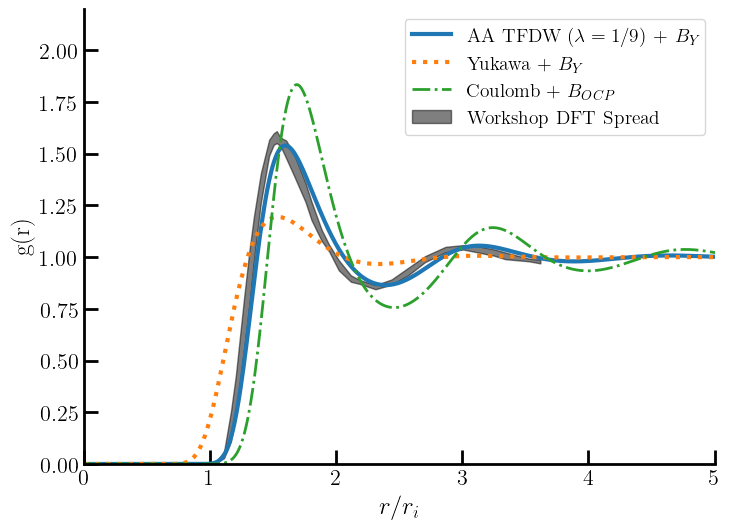

In [32]:
from pandas import read_csv
from scipy.interpolate import PchipInterpolator

fig,ax = plt.subplots(figsize=(8,6))

if aa_model.aa_type=='AA_TFD':
    type_label = r"AA {} + $B_Y$".format(aa_model.aa_type[3:])
elif aa_model.λ_W==1/9.:
    type_label = r"AA {0} ($\lambda=1/9$) + $B_Y$".format(aa_model.aa_type[3:])
else:
    type_label = r"AA {0} ($\lambda={1:0.3f}$) + $B_Y$".format(aa_model.aa_type[3:], aa_model.λ_W)
    
ax.plot(hnc.r_array,  hnc.h_r_matrix[0,0]+1,'-', label=type_label,linewidth=3)
ax.plot(hnc_Y.r_array,  hnc_Y.h_r_matrix[0,0]+1,':', label=r"Yukawa + $B_{Y}$", linewidth=3)
ax.plot(hnc_C.r_array,  hnc_C.h_r_matrix[0,0]+1,'-.', label=r"Coulomb + $B_{OCP}$")

     
# Data from community TCCW
upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Upper.txt", delim_whitespace=True, header=1)
lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Lower.txt", delim_whitespace=True, header=1)

ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')


ax.set_ylim(0, 2.2)
ax.set_xlim(0,5)
ax.legend(fontsize=14)

ax.set_ylabel('g(r)', fontsize=18)
ax.set_xlabel(r'$r/r_i$', fontsize=18)
ax.tick_params(labelsize=16)

# Text box for information			
props = dict(boxstyle='round', facecolor='w')
# ax.text(0.06,0.98, aa_model.nice_text, fontsize=15, transform=ax.transAxes, verticalalignment='top', bbox=props)

if aa_model.aa_type=='AA_TFD':
    λ_info=''
elif aa_model.λ_W==1/9.:
    λ_info='_λ=1over9'
else:
    λ_info='_λ=1'
plt.savefig(r'../media/preliminary_{0}{1}_BY_gofr_{2}{3:0.3f}eV.png'.format(aa_model.aa_type,λ_info,name,T_eV), dpi=200)
plt.tight_layout()

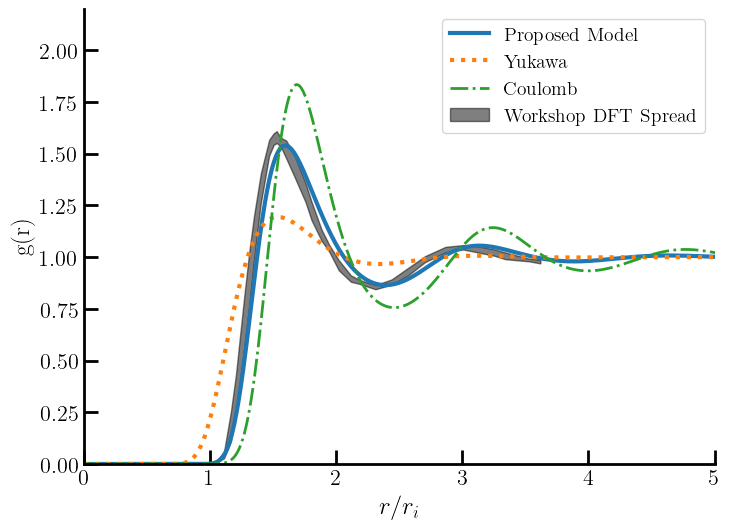

In [33]:
from pandas import read_csv
from scipy.interpolate import PchipInterpolator

fig,ax = plt.subplots(figsize=(8,6))


type_label = "Proposed Model"
    
ax.plot(hnc.r_array,  hnc.h_r_matrix[0,0]+1,'-', label=type_label,linewidth=3)
ax.plot(hnc_Y.r_array,  hnc_Y.h_r_matrix[0,0]+1,':', label="Yukawa", linewidth=3)
ax.plot(hnc_C.r_array,  hnc_C.h_r_matrix[0,0]+1,'-.', label="Coulomb")

     
# Data from community TCCW
upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Upper.txt", delim_whitespace=True, header=1)
lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Lower.txt", delim_whitespace=True, header=1)

ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')


ax.set_ylim(0, 2.2)
ax.set_xlim(0,5)
ax.legend(fontsize=14)

ax.set_ylabel('g(r)', fontsize=18)
ax.set_xlabel(r'$r/r_i$', fontsize=18)
ax.tick_params(labelsize=16)

# Text box for information			
props = dict(boxstyle='round', facecolor='w')
# ax.text(0.06,0.98, aa_model.nice_text, fontsize=15, transform=ax.transAxes, verticalalignment='top', bbox=props)

if aa_model.aa_type=='AA_TFD':
    λ_info=''
elif aa_model.λ_W==1/9.:
    λ_info='_λ=1over9'
else:
    λ_info='_λ=1'
plt.savefig(r'../media/preliminary_{0}{1}_BY_gofr_{2}{3:0.3f}eV.png'.format(aa_model.aa_type,λ_info,name,T_eV), dpi=200)
plt.tight_layout()

AttributeError: 'NeutralPseudoAtom' object has no attribute 'nice_text'

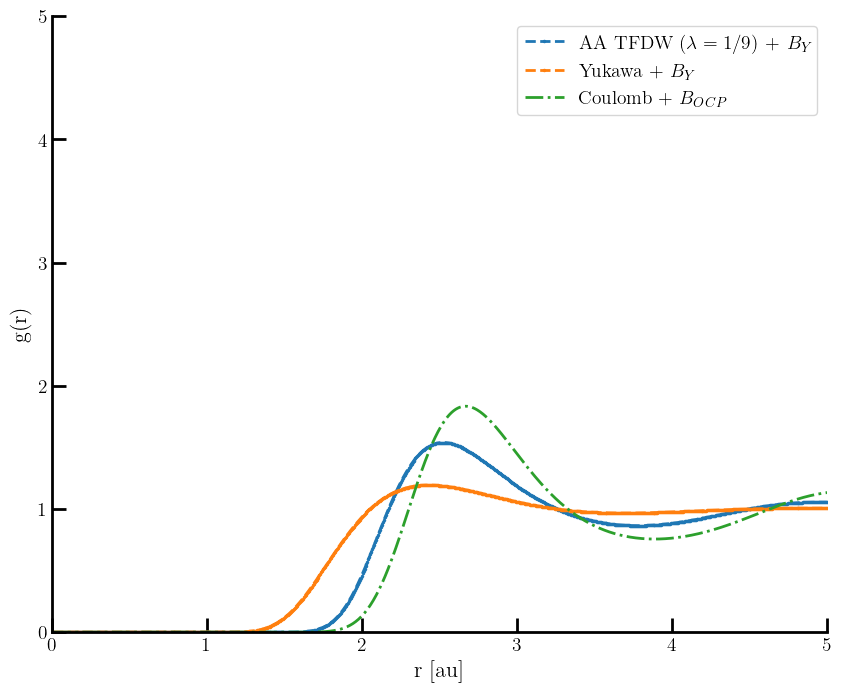

In [34]:
from pandas import read_csv
from scipy.interpolate import PchipInterpolator

fig,ax = plt.subplots(figsize=(10,8))

if aa_model.aa_type=='AA_TFD':
    type_label = r"AA {} + $B_Y$".format(aa_model.aa_type[3:])
elif aa_model.λ_W==1/9.:
    type_label = r"AA {0} ($\lambda=1/9$) + $B_Y$".format(aa_model.aa_type[3:])
else:
    type_label = r"AA {0} ($\lambda={1:0.3f}$) + $B_Y$".format(aa_model.aa_type[3:], aa_model.λ_W)
    
ax.plot(hnc.r_array*rs*AU_to_Angstrom,  hnc.h_r_matrix[0,0]+1,'--.', label=type_label)
ax.plot(hnc_Y.r_array*rs*AU_to_Angstrom,  hnc_Y.h_r_matrix[0,0]+1,'--.', label=r"Yukawa + $B_{Y}$")
ax.plot(hnc_C.r_array*rs*AU_to_Angstrom,  hnc_C.h_r_matrix[0,0]+1,'-.', label=r"Coulomb + $B_{OCP}$")

     
# Data from community TCCW
# upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5b_Upper.txt", delim_whitespace=True, header=1)
# lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5b_Lower.txt", delim_whitespace=True, header=1)

# ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')


ax.set_ylim(0, 5)
ax.set_xlim(0,5)
ax.legend(fontsize=14)

ax.set_ylabel('g(r)', fontsize=16)
ax.set_xlabel('r [au]', fontsize=16)
ax.tick_params(labelsize=14)

# Text box for information			
props = dict(boxstyle='round', facecolor='w')
ax.text(0.06,0.98, aa_model.nice_text, fontsize=15, transform=ax.transAxes, verticalalignment='top', bbox=props)

if aa_model.aa_type=='AA_TFD':
    λ_info=''
elif aa_model.λ_W==1/9.:
    λ_info='_λ=1over9'
else:
    λ_info='_λ=1'
plt.savefig(r'../media/preliminary_{0}{1}_BY_gofr_{2}{3:0.3f}eV.png'.format(aa_model.aa_type,λ_info,name,T_eV), dpi=200)

In [79]:
from hnc.hnc.misc import ThomasFermiZbar
aa_tfd.Zstar, ThomasFermiZbar( Z, n_from_rs(rs)*AU_to_invcc, T_eV)

(3.3001302804767327, 2.500739540788928)

## Fitting Potential

In [78]:
φ_func =  interp1d(lin.atom.grid.xs, φ_pseudo_TFDW_λover9, bounds_error = False, fill_value = (φ_pseudo_TFD[0], φ_pseudo_TFD[-1]) )#'extrapolate')
# δnf_func  =  lambda r: nf_func(r) - nf[-1]# - n0 # Free change from uniformity
φ =  φ_func(lin.r_list)
φ_tilde =  0.5*lin.dr*dst(4*np.pi* lin.r_list* φ,type=lin.dst_type)/lin.k_list

new_vii = ifft(lin.vii0_tilde + lin.χs * φ_tilde**2)


NameError: name 'dst' is not defined

In [ ]:
from scipy.optimize import curve_fit


# def coulomb_fit(r, Γ ):
#     return Γ/r 

Γ = 1/aa_model.T * aa_model.Zstar**2 /(rs)
def yukawa_fit(r, κ ):
    return Γ/r * np.exp(-κ*r)

def yukawa_oscillate_fit(r, a, κ1, κ2, θ, δ ):
    return np.exp(-κ1*r) + a * np.exp(-κ2*r)*np.cos(θ*r + δ)


# c_fit_vals = curve_fit(coulomb_fit, hnc.r_array[:100], hnc.βu_r_matrix[0,0][:100], p0=(1,1) )
# c_fit_vals

y_fit_vals = curve_fit(yukawa_fit, hnc.r_array, hnc.βu_r_matrix[0,0], p0=(1) )
y_fit_vals

y_osc_fit_vals = curve_fit(yukawa_oscillate_fit, hnc.r_array, hnc.βu_r_matrix[0,0]/yukawa_fit(hnc.r_array, *y_fit_vals[0]) , p0=(1, 1, 1, 0.001, 0.001) )
y_osc_fit_vals

In [ ]:
fig, ax  = plt.subplots()

# ax.plot(hnc.r_array*rs, aa_model.T*hnc.βu_r_matrix[0,0],'-',label=r'$v_{ii}^{\rm eff.}$')
# ax.plot(hnc.r_array*rs, aa_model.T*yukawa_fit(hnc.r_array, *y_fit_vals[0]),'--.',label=r'Fit Yukawa')
# ax.plot(hnc.r_array*rs, aa_model.T*yukawa_fit(hnc.r_array, 3),'--.',label=r'Fit Yukawa')
ax.plot(hnc.r_array*rs, aa_model.T*hnc.βu_r_matrix[0,0]/ (aa_model.T*yukawa_fit(hnc.r_array, 0) )  ,'-',label=r'Potential over Yukawa')
ax.plot(hnc.r_array*rs, yukawa_oscillate_fit(hnc.r_array, 2, 1, 10, 5,-0.25 * 2*π) ,'--.',label=r'Fit Yukawa')


# ax.plot(hnc.r_array*rs, aa_model.T*yukawa_oscillate_fit(hnc.r_array,  1, 5, 0.1),'--.',label=r'custom')


ax.set_xscale('log')
# ax.set_yscale('symlog',linthresh=1e-5)

# ax.set_xlim(5,None)
# ax.set_ylim(-0.01,None)

ax.legend(fontsize=14)